# ASSIGNMENT 3

## Part 1 - Gaussian and Multinomial HMM on ionosphere and breast cancer datasets

In [1]:
%pip install hmmlearn scikit-learn pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc)
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')



In [3]:
# ========================================================================
# Cell 3: Settings and Configuration
# ========================================================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

TRAIN_SPLITS = [0.6, 0.7, 0.8]
N_COMPONENTS_GRID = [2, 4, 6, 8]
COVARIANCE_TYPES = ['diag', 'full']
N_BINS_GRID = [3, 5, 8, 10, 15, 20]
N_ITER = 200
SAVE_FIGS = True
DISCRETIZATION_STRATEGIES = ['uniform', 'quantile', 'kmeans']


In [4]:
# ========================================================================
# Cell 4: Load Datasets
# ========================================================================
def load_ionosphere_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
    column_names = [f'feature_{i}' for i in range(34)] + ['class']
    df = pd.read_csv(url, names=column_names, header=None)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['class'])
    X = df.drop('class', axis=1).values
    return X, y, 'Ionosphere'

def load_breast_cancer_data():
    data = load_breast_cancer()
    X, y = data.data, data.target
    return X, y, 'Breast_Cancer'

print("Loading datasets...")
datasets = {
    'Ionosphere': load_ionosphere_data(),
    'Breast_Cancer': load_breast_cancer_data()
}
print("Datasets loaded successfully!\n")



Loading datasets...
Datasets loaded successfully!



In [5]:
# ========================================================================
# Cell 5: Helper Functions for Sequence Representation
# ========================================================================
def make_sequence_from_sample(x):
    return x.reshape(-1, 1)

def prepare_sequences(X):
    return [make_sequence_from_sample(x) for x in X]


In [6]:
# ========================================================================
# Cell 6: HMM Training and Prediction Functions
# ========================================================================
def train_hmm_models_per_class(X_train, y_train, n_components, covariance_type='diag', 
                                n_iter=100, model_type='gaussian'):
    models = {}
    classes = np.unique(y_train)
    
    for cls in classes:
        class_indices = np.where(y_train == cls)[0]
        class_sequences = [X_train[i] for i in class_indices]
        lengths = [len(seq) for seq in class_sequences]
        X_concat = np.vstack(class_sequences)
        
        if model_type == 'gaussian':
            model = hmm.GaussianHMM(
                n_components=n_components,
                covariance_type=covariance_type,
                n_iter=n_iter,
                random_state=RANDOM_STATE,
                verbose=False
            )
        else:
            model = hmm.MultinomialHMM(
                n_components=n_components,
                n_iter=n_iter,
                random_state=RANDOM_STATE,
                verbose=False
            )
        
        model.fit(X_concat, lengths)
        models[cls] = model
    return models


def predict_with_hmms(models, X_test):
    n_samples = len(X_test)
    classes = sorted(models.keys())
    scores = np.zeros((n_samples, len(classes)))
    
    for i, seq in enumerate(X_test):
        for j, cls in enumerate(classes):
            try:
                scores[i, j] = models[cls].score(seq)
            except:
                scores[i, j] = -np.inf
    predictions = np.array([classes[np.argmax(scores[i])] for i in range(n_samples)])
    return predictions, scores


In [7]:
# ========================================================================
# Cell 7: Evaluation Functions
# ========================================================================
def evaluate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

def compute_roc_auc(y_true, scores):
    if scores.shape[1] == 2:
        decision_scores = scores[:, 1] - scores[:, 0]
    else:
        decision_scores = scores[:, 1]
    fpr, tpr, _ = roc_curve(y_true, decision_scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc


In [8]:
# ========================================================================
# Cell 8: Visualization Functions
# ========================================================================
def plot_confusion_heatmap(cm, title, filename):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()


def plot_roc_curve(fpr, tpr, roc_auc, title, filename):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()


def plot_training_curve(model, title, filename):
    try:
        if hasattr(model, 'monitor_') and hasattr(model.monitor_, 'history'):
            history = model.monitor_.history
            if len(history) > 0:
                plt.figure(figsize=(6, 4))
                plt.plot(history, marker='o', markersize=3)
                plt.xlabel('Iteration')
                plt.ylabel('Log Likelihood')
                plt.title(title)
                plt.grid(alpha=0.3)
                plt.tight_layout()
                if SAVE_FIGS:
                    plt.savefig(filename, dpi=150, bbox_inches='tight')
                plt.show()
            else:
                print(f"No training history available for {title}")
        else:
            print(f"Model monitor not available for {title}")
    except Exception as e:
        print(f"Could not plot training curve for {title}: {e}")


In [9]:
# ========================================================================
# Cell 9: Main Experiment Loop
# ========================================================================
results = []
best_models = {}

for dataset_name, (X, y, name) in datasets.items():
    print(f"\n{'='*70}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*70}")
    print(f"Shape: {X.shape}, Classes: {np.unique(y)}")
    
    # ------------------- GaussianHMM -------------------
    print(f"\n--- GaussianHMM for {dataset_name} ---")
    best_gaussian_f1 = 0
    best_gaussian_config = None
    
    for split_ratio in TRAIN_SPLITS:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=split_ratio, random_state=RANDOM_STATE, stratify=y
        )
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_seq = prepare_sequences(X_train_scaled)
        X_test_seq = prepare_sequences(X_test_scaled)
        
        for n_comp in N_COMPONENTS_GRID:
            for cov_type in COVARIANCE_TYPES:
                try:
                    models = train_hmm_models_per_class(X_train_seq, y_train, n_comp, cov_type, N_ITER, 'gaussian')
                    y_pred, scores = predict_with_hmms(models, X_test_seq)
                    metrics = evaluate_metrics(y_test, y_pred)
                    fpr, tpr, roc_auc = compute_roc_auc(y_test, scores)
                    
                    result = {
                        'dataset': dataset_name, 'classifier': 'GaussianHMM', 'split': split_ratio,
                        'n_components': n_comp, 'covariance_type': cov_type, 'n_bins': None,
                        'accuracy': metrics['accuracy'], 'precision': metrics['precision'],
                        'recall': metrics['recall'], 'f1': metrics['f1'], 'auc': roc_auc,
                        'confusion_matrix': metrics['confusion_matrix']
                    }
                    results.append(result)
                    
                    if metrics['f1'] > best_gaussian_f1:
                        best_gaussian_f1 = metrics['f1']
                        best_gaussian_config = {
                            'models': models, 'scaler': scaler, 'result': result,
                            'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc,
                            'y_test': y_test, 'y_pred': y_pred, 'X_test_seq': X_test_seq
                        }
                except Exception as e:
                    print(f"Error with n_comp={n_comp}, cov={cov_type}: {e}")
    
    if best_gaussian_config:
        best_models[f'{dataset_name}_GaussianHMM'] = best_gaussian_config
        print(f"Best GaussianHMM F1: {best_gaussian_f1:.4f}")
    
    # ------------------- MultinomialHMM -------------------
    print(f"\n--- MultinomialHMM for {dataset_name} ---")
    best_multinomial_f1 = 0
    best_multinomial_config = None
    
    for split_ratio in TRAIN_SPLITS:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=split_ratio, random_state=RANDOM_STATE, stratify=y
        )
        for n_bins in N_BINS_GRID:
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile', random_state=RANDOM_STATE)
            X_train_disc = discretizer.fit_transform(X_train).astype(int)
            X_test_disc = discretizer.transform(X_test).astype(int)
            X_train_seq = prepare_sequences(X_train_disc)
            X_test_seq = prepare_sequences(X_test_disc)
            
            for n_comp in N_COMPONENTS_GRID:
                try:
                    models = train_hmm_models_per_class(X_train_seq, y_train, n_comp, None, N_ITER, 'multinomial')
                    y_pred, scores = predict_with_hmms(models, X_test_seq)
                    metrics = evaluate_metrics(y_test, y_pred)
                    fpr, tpr, roc_auc = compute_roc_auc(y_test, scores)
                    
                    result = {
                        'dataset': dataset_name, 'classifier': 'MultinomialHMM', 'split': split_ratio,
                        'n_components': n_comp, 'covariance_type': None, 'n_bins': n_bins,
                        'accuracy': metrics['accuracy'], 'precision': metrics['precision'],
                        'recall': metrics['recall'], 'f1': metrics['f1'], 'auc': roc_auc,
                        'confusion_matrix': metrics['confusion_matrix']
                    }
                    results.append(result)
                    
                    if metrics['f1'] > best_multinomial_f1:
                        best_multinomial_f1 = metrics['f1']
                        best_multinomial_config = {
                            'models': models, 'discretizer': discretizer, 'result': result,
                            'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc,
                            'y_test': y_test, 'y_pred': y_pred, 'X_test_seq': X_test_seq
                        }
                except Exception as e:
                    print(f"Error with n_bins={n_bins}, n_comp={n_comp}: {e}")
    
    if best_multinomial_config:
        best_models[f'{dataset_name}_MultinomialHMM'] = best_multinomial_config
        print(f"Best MultinomialHMM F1: {best_multinomial_f1:.4f}")



DATASET: Ionosphere
Shape: (351, 34), Classes: [0 1]

--- GaussianHMM for Ionosphere ---
Best GaussianHMM F1: 0.9290

--- MultinomialHMM for Ionosphere ---
Best MultinomialHMM F1: 0.7816

DATASET: Breast_Cancer
Shape: (569, 30), Classes: [0 1]

--- GaussianHMM for Breast_Cancer ---
Best GaussianHMM F1: 0.9441

--- MultinomialHMM for Breast_Cancer ---
Best MultinomialHMM F1: 0.7742



GENERATING VISUALIZATIONS FOR BEST MODELS


Visualizing: Ionosphere_GaussianHMM


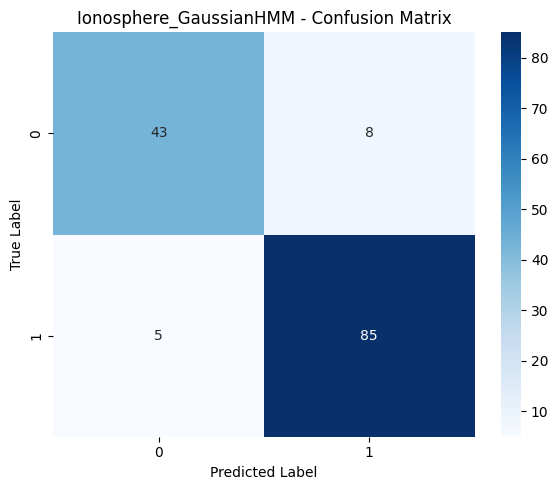

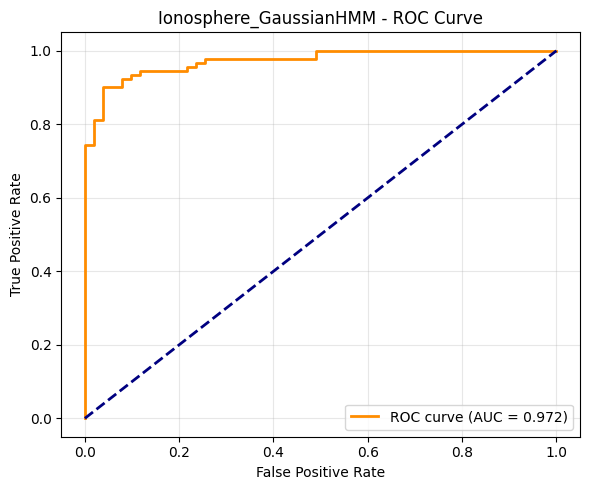

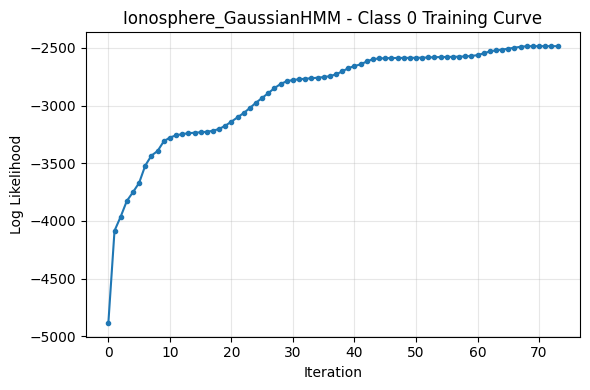


Visualizing: Ionosphere_MultinomialHMM


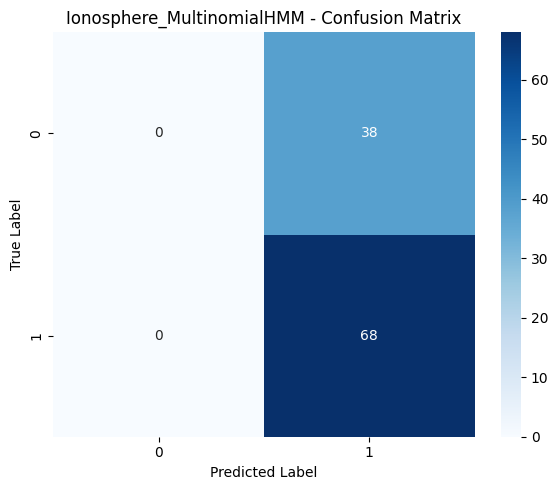

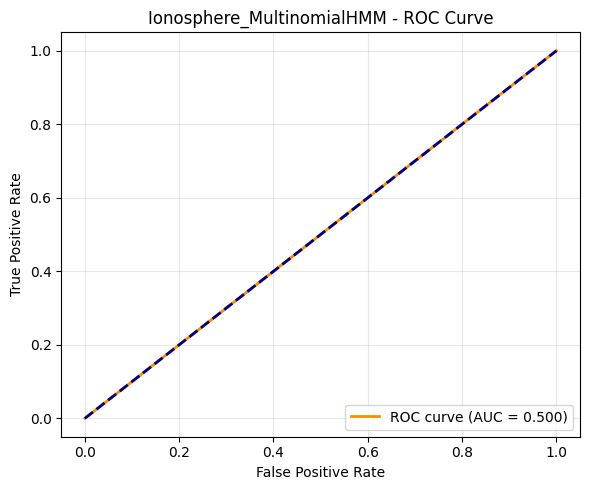

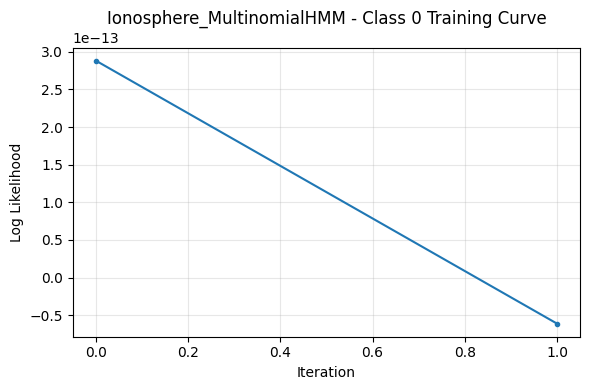


Visualizing: Breast_Cancer_GaussianHMM


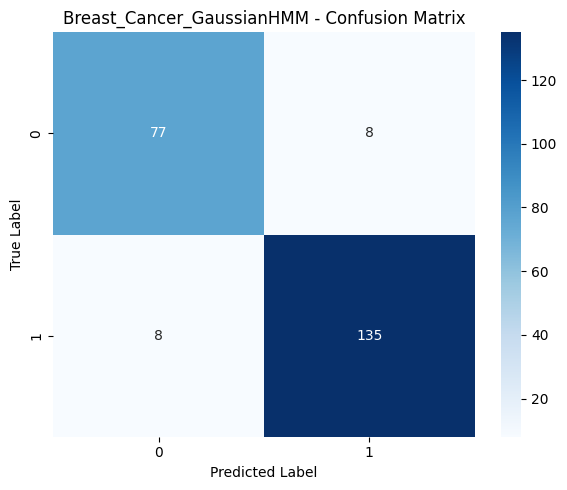

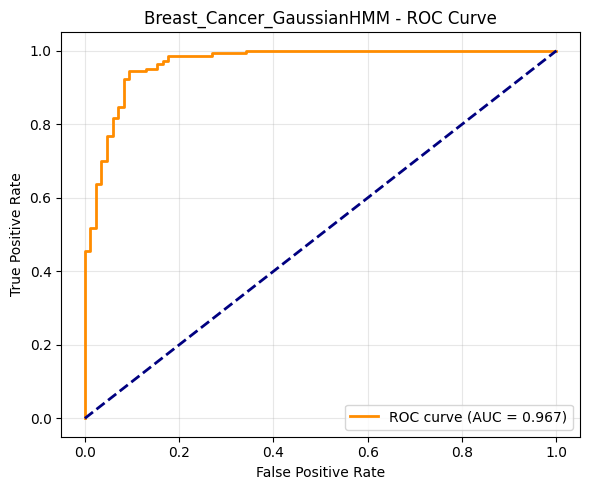

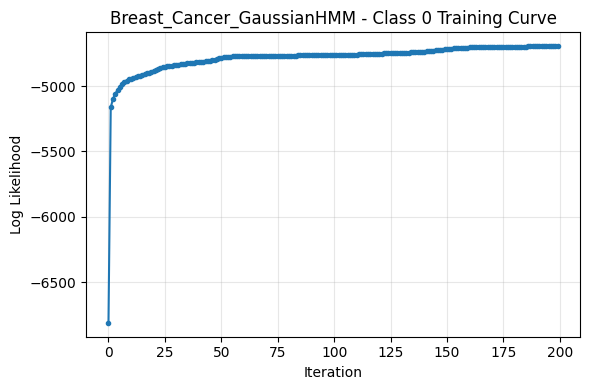


Visualizing: Breast_Cancer_MultinomialHMM


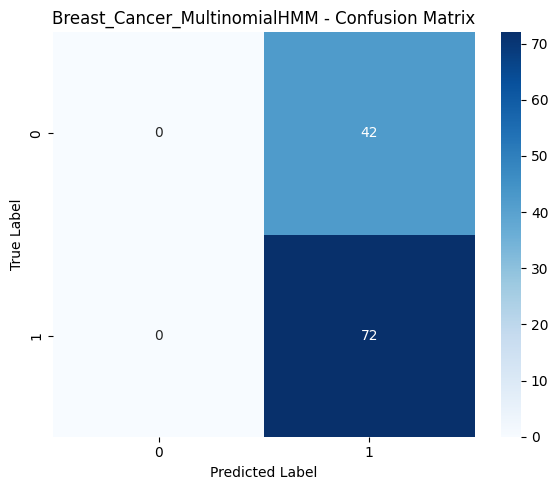

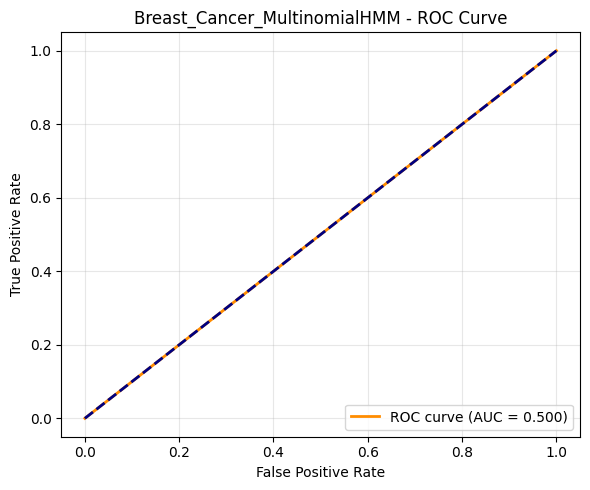

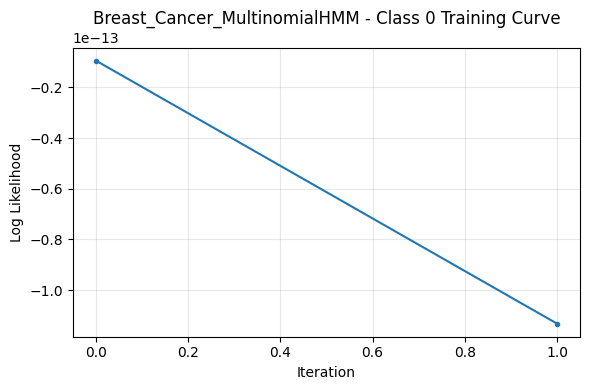

In [10]:
# ========================================================================
# Cell 10: Generate Visualizations for Best Models
# ========================================================================
print(f"\n{'='*70}")
print("GENERATING VISUALIZATIONS FOR BEST MODELS")
print(f"{'='*70}\n")

for model_key, config in best_models.items():
    print(f"\nVisualizing: {model_key}")
    result = config['result']

    cm_title = f"{model_key} - Confusion Matrix"
    cm_filename = f"fig_confusion_{model_key.lower().replace(' ', '_')}.png"
    plot_confusion_heatmap(result['confusion_matrix'], cm_title, cm_filename)

    roc_title = f"{model_key} - ROC Curve"
    roc_filename = f"fig_roc_{model_key.lower().replace(' ', '_')}.png"
    plot_roc_curve(config['fpr'], config['tpr'], config['roc_auc'],
                   roc_title, roc_filename)

    for cls, model in config['models'].items():
        train_title = f"{model_key} - Class {cls} Training Curve"
        train_filename = f"fig_train_{model_key.lower().replace(' ', '_')}_class{cls}.png"
        plot_training_curve(model, train_title, train_filename)
        break


In [11]:
# ========================================================================
# Cell 11: Summary Table
# ========================================================================
print(f"\n{'='*70}")
print("SUMMARY TABLE: BEST RESULTS")
print(f"{'='*70}\n")

summary_data = []
for model_key, config in best_models.items():
    result = config['result']
    summary_data.append({
        'Model': model_key,
        'Best Split': f"{result['split']:.1f}",
        'N Components': result['n_components'],
        'Covariance/Bins': result['covariance_type'] if result['covariance_type'] else f"{result['n_bins']} bins",
        'Accuracy': f"{result['accuracy']:.4f}",
        'Precision': f"{result['precision']:.4f}",
        'Recall': f"{result['recall']:.4f}",
        'F1-Score': f"{result['f1']:.4f}",
        'AUC': f"{result['auc']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))



SUMMARY TABLE: BEST RESULTS

                       Model Best Split  N Components Covariance/Bins Accuracy Precision Recall F1-Score    AUC
      Ionosphere_GaussianHMM        0.6             8            diag   0.9078    0.9140 0.9444   0.9290 0.9723
   Ionosphere_MultinomialHMM        0.7             2          3 bins   0.6415    0.6415 1.0000   0.7816 0.5000
   Breast_Cancer_GaussianHMM        0.6             6            diag   0.9298    0.9441 0.9441   0.9441 0.9668
Breast_Cancer_MultinomialHMM        0.8             8          3 bins   0.6316    0.6316 1.0000   0.7742 0.5000


In [12]:
# ========================================================================
# Cell 12: Detailed Results + CSV Export
# ========================================================================
print(f"\n{'='*70}")
print("DETAILED RESULTS (All Experiments)")
print(f"{'='*70}\n")

results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'confusion_matrix'}
                           for r in results])
print(results_df.head(20))

results_df.to_csv('hmm_classification_results.csv', index=False)
print("\nDetailed results saved to 'hmm_classification_results.csv'")



DETAILED RESULTS (All Experiments)

       dataset   classifier  split  n_components covariance_type  n_bins  \
0   Ionosphere  GaussianHMM    0.6             2            diag     NaN   
1   Ionosphere  GaussianHMM    0.6             2            full     NaN   
2   Ionosphere  GaussianHMM    0.6             4            diag     NaN   
3   Ionosphere  GaussianHMM    0.6             4            full     NaN   
4   Ionosphere  GaussianHMM    0.6             6            diag     NaN   
5   Ionosphere  GaussianHMM    0.6             6            full     NaN   
6   Ionosphere  GaussianHMM    0.6             8            diag     NaN   
7   Ionosphere  GaussianHMM    0.6             8            full     NaN   
8   Ionosphere  GaussianHMM    0.7             2            diag     NaN   
9   Ionosphere  GaussianHMM    0.7             2            full     NaN   
10  Ionosphere  GaussianHMM    0.7             4            diag     NaN   
11  Ionosphere  GaussianHMM    0.7             4   

In [13]:
# ========================================================================
# Cell 13: Check Accuracy Threshold and Provide Suggestions
# ========================================================================
print(f"\n{'='*70}")
print("PERFORMANCE ANALYSIS")
print(f"{'='*70}\n")

threshold = 0.90
needs_improvement = []

for model_key, config in best_models.items():
    result = config['result']
    acc = result['accuracy']
    print(f"{model_key}: Accuracy = {acc:.4f} ({acc*100:.2f}%)")
    if acc < threshold:
        needs_improvement.append(model_key)

if needs_improvement:
    print(f"\n⚠️  Models with accuracy < 90%: {', '.join(needs_improvement)}")
    print("\nSCOPE FOR IMPROVEMENT:")
    print("1. Feature Engineering: Create domain-specific features or apply PCA/LDA")
    print("2. Alternative Sequence Construction: Use sliding windows or feature grouping")
    print("3. Increase Hidden States: Try n_components > 8 (e.g., 10, 12, 16)")
    print("4. Ensemble Methods: Combine multiple HMMs or use voting")
    print("5. Advanced Preprocessing: Try different scaling/discretization strategies")
    print("6. Hybrid Approach: Use HMM features as input to traditional ML classifiers")
    print("7. Temporal Features: If applicable, create artificial temporal structure")
    print("8. Cross-validation: Use k-fold CV for more robust hyperparameter selection")
else:
    print("\n✓ All models achieved ≥90% accuracy!")

print("\n" + "="*70)
print("EXPERIMENT COMPLETE!")
print("="*70)



PERFORMANCE ANALYSIS

Ionosphere_GaussianHMM: Accuracy = 0.9078 (90.78%)
Ionosphere_MultinomialHMM: Accuracy = 0.6415 (64.15%)
Breast_Cancer_GaussianHMM: Accuracy = 0.9298 (92.98%)
Breast_Cancer_MultinomialHMM: Accuracy = 0.6316 (63.16%)

⚠️  Models with accuracy < 90%: Ionosphere_MultinomialHMM, Breast_Cancer_MultinomialHMM

SCOPE FOR IMPROVEMENT:
1. Feature Engineering: Create domain-specific features or apply PCA/LDA
2. Alternative Sequence Construction: Use sliding windows or feature grouping
3. Increase Hidden States: Try n_components > 8 (e.g., 10, 12, 16)
4. Ensemble Methods: Combine multiple HMMs or use voting
5. Advanced Preprocessing: Try different scaling/discretization strategies
6. Hybrid Approach: Use HMM features as input to traditional ML classifiers
7. Temporal Features: If applicable, create artificial temporal structure
8. Cross-validation: Use k-fold CV for more robust hyperparameter selection

EXPERIMENT COMPLETE!


PART 2 of Assignment:

In [1]:
# CNN Classification on CIFAR-10 and MNIST Datasets
# ==================================================

# Install required packages
!pip install scikit-plot tensorflow


## PART 2 - Using CNN on CIFAR-10 and MNIST

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# ====================================================================
# UTILITY FUNCTIONS
# ====================================================================

def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_training_history(history, title, filename):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_roc_auc_multiclass(y_true, y_pred_proba, n_classes, class_names, title, filename):
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(12, 10))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
             color='deeppink', linestyle=':', linewidth=4)

    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(min(n_classes, 10)):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return roc_auc["micro"]


In [4]:
# ====================================================================
# MODEL ARCHITECTURES
# ====================================================================

def create_cnn_model_cifar10(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


def create_cnn_model_mnist(input_shape=(28, 28, 1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [5]:
# ====================================================================
# TRAINING FUNCTION
# ====================================================================

def train_and_evaluate(X_train, X_test, y_train, y_test,
                       model_creator, dataset_name, split_ratio,
                       epochs=100, batch_size=128):

    print(f"\n{'='*80}")
    print(f"Training {dataset_name} with {split_ratio} train-test split")
    print(f"{'='*80}")

    model = model_creator()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    return model, history, y_true, y_pred, y_pred_proba, test_accuracy, test_loss


In [6]:
# ====================================================================
# CIFAR-10 DATASET EXPERIMENTS
# ====================================================================

print("\n" + "="*80)
print("CIFAR-10 DATASET EXPERIMENTS")
print("="*80)

(X_cifar_train_full, y_cifar_train_full), (X_cifar_test, y_cifar_test) = cifar10.load_data()

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nOriginal CIFAR-10 shapes:")
print(f"Training: {X_cifar_train_full.shape}, Testing: {X_cifar_test.shape}")

X_cifar_train_full = X_cifar_train_full.astype('float32') / 255.0
X_cifar_test = X_cifar_test.astype('float32') / 255.0

y_cifar_train_full = y_cifar_train_full.flatten()
y_cifar_test = y_cifar_test.flatten()

cifar10_results = []
split_ratios = [0.6, 0.7, 0.8]

for split_ratio in split_ratios:
    X_train, X_val, y_train, y_val = train_test_split(
        X_cifar_train_full, y_cifar_train_full,
        train_size=split_ratio, random_state=42, stratify=y_cifar_train_full
    )

    y_train_cat = to_categorical(y_train, 10)
    y_val_cat = to_categorical(y_val, 10)
    y_test_cat = to_categorical(y_cifar_test, 10)

    print(f"\nSplit {int(split_ratio*100)}-{round((1-split_ratio)*100)} shapes:")
    print(f"Train: {X_train.shape}, Validation: {X_val.shape}")

    model, history, y_true, y_pred, y_pred_proba, test_acc, test_loss = train_and_evaluate(
        X_train, X_cifar_test, y_train_cat, y_test_cat,
        create_cnn_model_cifar10,
        f"CIFAR-10 ({int(split_ratio*100)}-{round((1-split_ratio)*100)} split)",
        f"{int(split_ratio*100)}-{round((1-split_ratio)*100)}",
        epochs=100,
        batch_size=128
    )

    cifar10_results.append({
        'Split': f"{int(split_ratio*100)}-{round((1-split_ratio)*100)}",
        'Train Size': len(X_train),
        'Test Size': len(X_cifar_test),
        'Test Accuracy': test_acc,
        'Test Loss': test_loss,
        'Model': model,
        'History': history,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    })

best_cifar10 = max(cifar10_results, key=lambda x: x['Test Accuracy'])
print(f"\nBest CIFAR-10 Model: {best_cifar10['Split']} split")
print(f"Best Test Accuracy: {best_cifar10['Test Accuracy']*100:.2f}%")



CIFAR-10 DATASET EXPERIMENTS
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 795s 5us/step

Original CIFAR-10 shapes:
Training: (50000, 32, 32, 3), Testing: (10000, 32, 32, 3)

Split 60-40 shapes:
Train: (30000, 32, 32, 3), Validation: (20000, 32, 32, 3)

Training CIFAR-10 (60-40 split) with 60-40 train-test split


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 849,066 (3.24 MB)

 Trainable params: 847,402 (3.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.2510 - loss: 2.4838 - val_accuracy: 0.1065 - val_loss: 3.8322 - learning_rate: 0.0010
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4516 - loss: 1.5280 - val_accuracy: 0.3180 - val_loss: 1.9882 - learning_rate: 0.0010
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5463 - loss: 1.2571 - val_accuracy: 0.5983 - val_loss: 1.1415 - learning_rate: 0.0010
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6167 - loss: 1.0852 - val_accuracy: 0.6532 - val_loss: 0.9869 - learning_rate: 0.0010
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6628 - loss: 0.9664 - val_accuracy: 0.6893 - val_loss: 0.8955 - learning_rate: 0.0010
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6935 - loss: 0.8782 - val_accuracy: 0.6411 - val_loss: 1.0516 - learning_rate: 0.0010
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7167 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 849,066 (3.24 MB)

 Trainable params: 847,402 (3.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.2571 - loss: 2.4608 - val_accuracy: 0.1756 - val_loss: 3.1506 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4508 - loss: 1.5100 - val_accuracy: 0.5019 - val_loss: 1.3635 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5597 - loss: 1.2172 - val_accuracy: 0.6187 - val_loss: 1.0673 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6270 - loss: 1.0448 - val_accuracy: 0.6662 - val_loss: 0.9543 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6711 - loss: 0.9321 - val_accuracy: 0.6973 - val_loss: 0.8535 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7007 - loss: 0.8549 - val_accuracy: 0.7449 - val_loss: 0.7157 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7269 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 849,066 (3.24 MB)

 Trainable params: 847,402 (3.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - accuracy: 0.2654 - loss: 2.4352 - val_accuracy: 0.1215 - val_loss: 4.6751 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4727 - loss: 1.4590 - val_accuracy: 0.5467 - val_loss: 1.2602 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5729 - loss: 1.1872 - val_accuracy: 0.6497 - val_loss: 1.0071 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6435 - loss: 1.0199 - val_accuracy: 0.6610 - val_loss: 1.0209 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6786 - loss: 0.9219 - val_accuracy: 0.7235 - val_loss: 0.8058 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7106 - loss: 0.8442 - val_accuracy: 0.7320 - val_loss: 0.7729 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7379 -

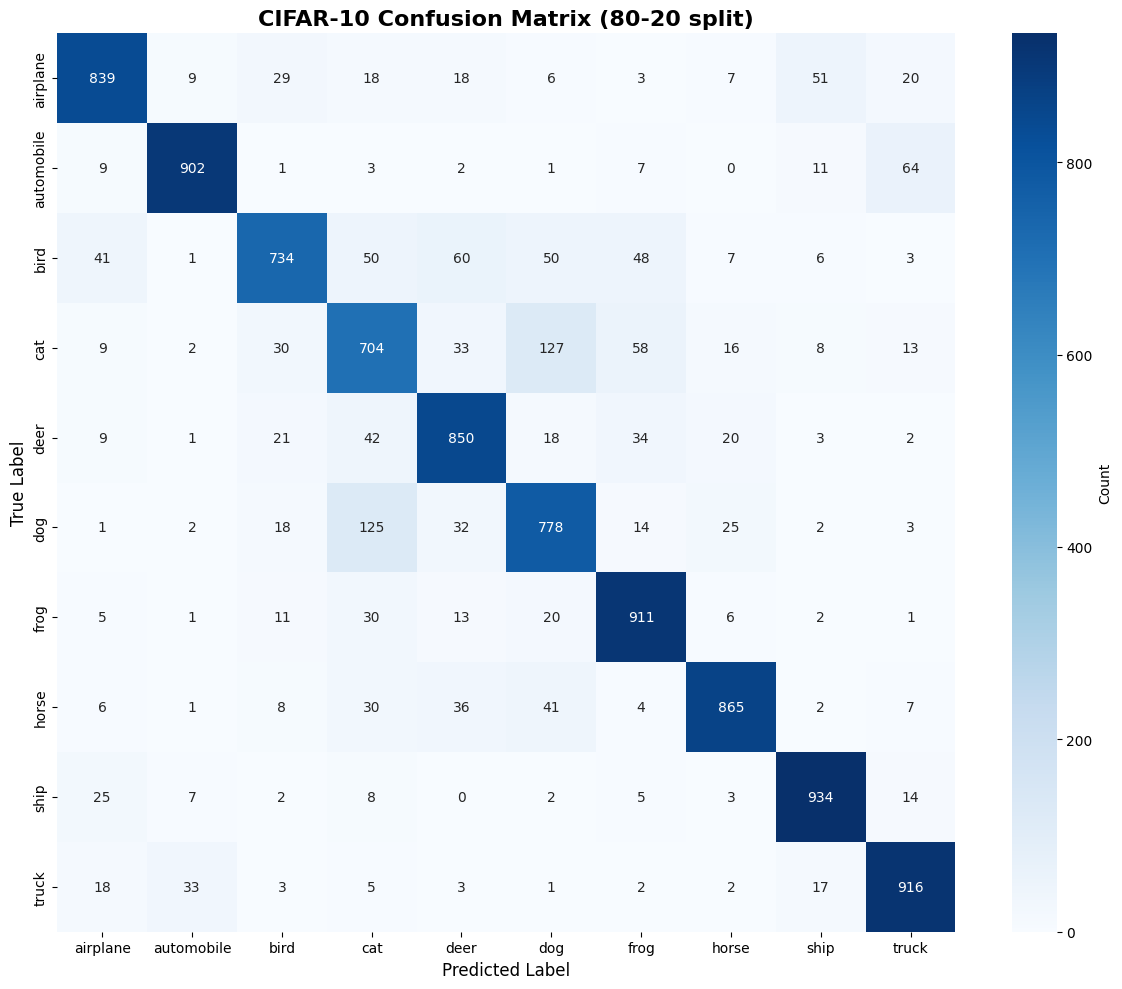

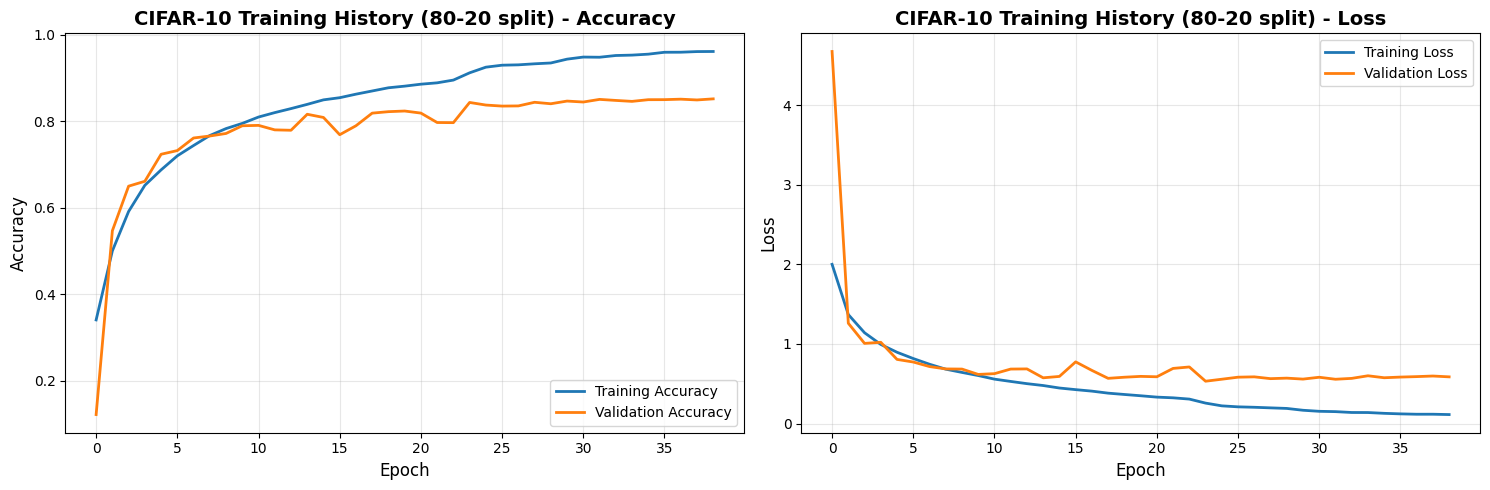

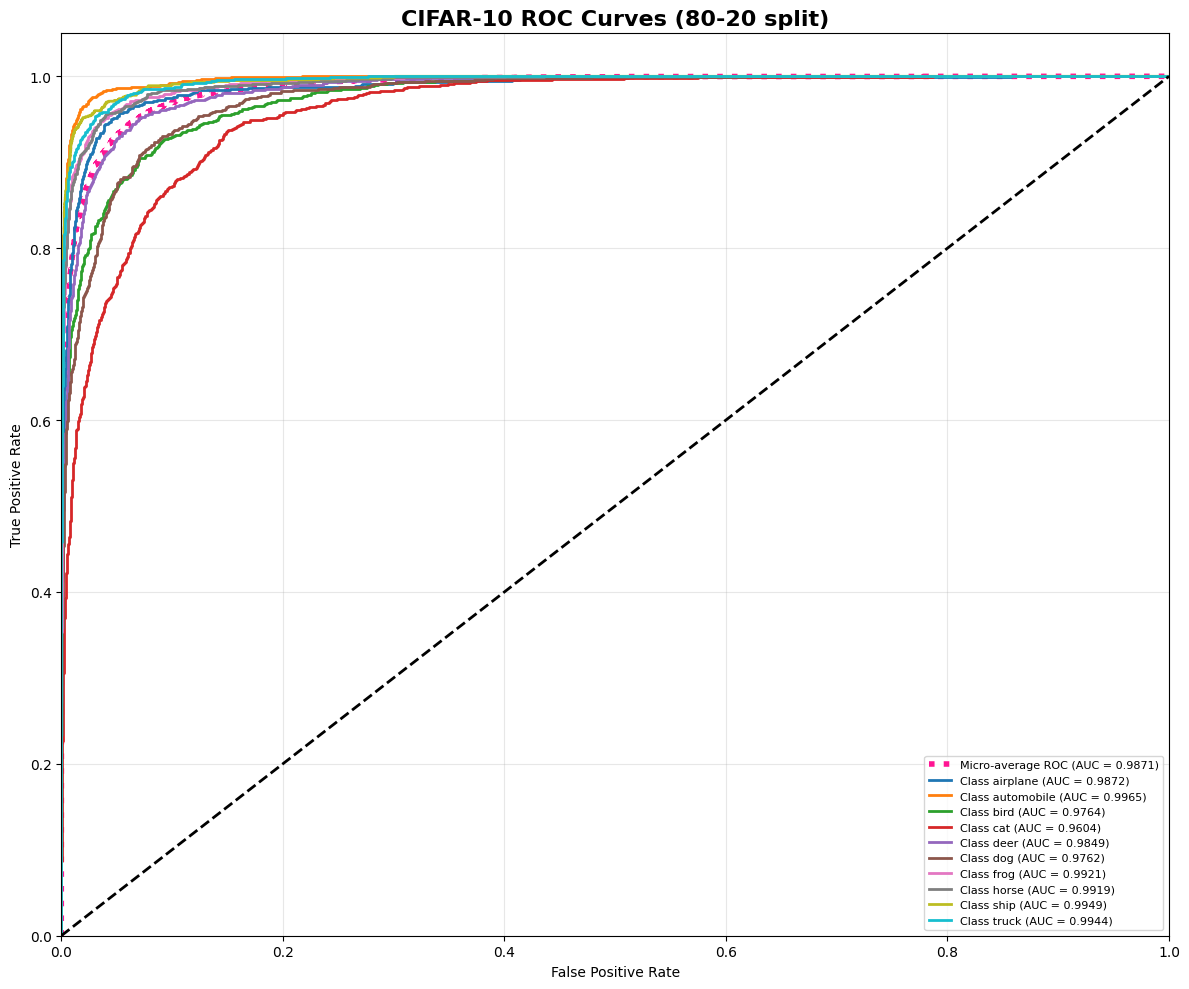

In [7]:
# Visualizations for best CIFAR-10 model
plot_confusion_matrix(best_cifar10['y_true'], best_cifar10['y_pred'],
                      cifar10_classes, f"CIFAR-10 Confusion Matrix ({best_cifar10['Split']} split)",
                      'cifar10_confusion_matrix_best.png')

plot_training_history(best_cifar10['History'],
                      f"CIFAR-10 Training History ({best_cifar10['Split']} split)",
                      'cifar10_training_curves_best.png')

cifar10_auc = plot_roc_auc_multiclass(best_cifar10['y_true'], best_cifar10['y_pred_proba'],
                                      10, cifar10_classes,
                                      f"CIFAR-10 ROC Curves ({best_cifar10['Split']} split)",
                                      'cifar10_roc_auc_best.png')


In [8]:
# ====================================================================
# MNIST DATASET EXPERIMENTS
# ====================================================================

print("\n" + "="*80)
print("MNIST DATASET EXPERIMENTS")
print("="*80)

(X_mnist_train_full, y_mnist_train_full), (X_mnist_test, y_mnist_test) = mnist.load_data()

mnist_classes = ['0','1','2','3','4','5','6','7','8','9']

X_mnist_train_full = X_mnist_train_full.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_mnist_test = X_mnist_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

mnist_results = []

for split_ratio in split_ratios:
    X_train, X_val, y_train, y_val = train_test_split(
        X_mnist_train_full, y_mnist_train_full,
        train_size=split_ratio, random_state=42, stratify=y_mnist_train_full
    )

    y_train_cat = to_categorical(y_train, 10)
    y_val_cat = to_categorical(y_val, 10)
    y_test_cat = to_categorical(y_mnist_test, 10)

    print(f"\nSplit {int(split_ratio*100)}-{round((1-split_ratio)*100)} shapes:")
    print(f"Train: {X_train.shape}, Validation: {X_val.shape}")

    model, history, y_true, y_pred, y_pred_proba, test_acc, test_loss = train_and_evaluate(
        X_train, X_mnist_test, y_train_cat, y_test_cat,
        create_cnn_model_mnist,
        f"MNIST ({int(split_ratio*100)}-{round((1-split_ratio)*100)} split)",
        f"{int(split_ratio*100)}-{round((1-split_ratio)*100)}",
        epochs=50,
        batch_size=128
    )

    mnist_results.append({
        'Split': f"{int(split_ratio*100)}-{round((1-split_ratio)*100)}",
        'Train Size': len(X_train),
        'Test Size': len(X_mnist_test),
        'Test Accuracy': test_acc,
        'Test Loss': test_loss,
        'Model': model,
        'History': history,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    })

best_mnist = max(mnist_results, key=lambda x: x['Test Accuracy'])
print(f"\nBest MNIST Model: {best_mnist['Split']} split")
print(f"Best Test Accuracy: {best_mnist['Test Accuracy']*100:.2f}%")



MNIST DATASET EXPERIMENTS
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Split 60-40 shapes:
Train: (36000, 28, 28, 1), Validation: (24000, 28, 28, 1)

Training MNIST (60-40 split) with 60-40 train-test split


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128)            │           51

 Total params: 471,018 (1.80 MB)

 Trainable params: 469,610 (1.79 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.6436 - loss: 1.2028 - val_accuracy: 0.1135 - val_loss: 9.1568 - learning_rate: 0.0010
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9534 - loss: 0.1559 - val_accuracy: 0.9634 - val_loss: 0.1226 - learning_rate: 0.0010
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9718 - loss: 0.0954 - val_accuracy: 0.9907 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9765 - loss: 0.0759 - val_accuracy: 0.9909 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9817 - loss: 0.0625 - val_accuracy: 0.9901 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9832 - loss: 0.0544 - val_accuracy: 0.9924 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9845 - loss: 0

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 128)            │           51

 Total params: 471,018 (1.80 MB)

 Trainable params: 469,610 (1.79 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.6615 - loss: 1.1432 - val_accuracy: 0.2333 - val_loss: 3.5989 - learning_rate: 0.0010
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9585 - loss: 0.1394 - val_accuracy: 0.9848 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9734 - loss: 0.0889 - val_accuracy: 0.9900 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9787 - loss: 0.0694 - val_accuracy: 0.9904 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9835 - loss: 0.0589 - val_accuracy: 0.9910 - val_loss: 0.0273 - learning_rate: 0.0010
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9851 - loss: 0.0527 - val_accuracy: 0.9900 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9856 - loss: 0

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 128)            │           51

 Total params: 471,018 (1.80 MB)

 Trainable params: 469,610 (1.79 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.6965 - loss: 1.0246 - val_accuracy: 0.1135 - val_loss: 7.1824 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9640 - loss: 0.1217 - val_accuracy: 0.9840 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9766 - loss: 0.0810 - val_accuracy: 0.9905 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9819 - loss: 0.0627 - val_accuracy: 0.9911 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9847 - loss: 0.0530 - val_accuracy: 0.9910 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9853 - loss: 0.0495 - val_accuracy: 0.9910 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9876 - loss: 0

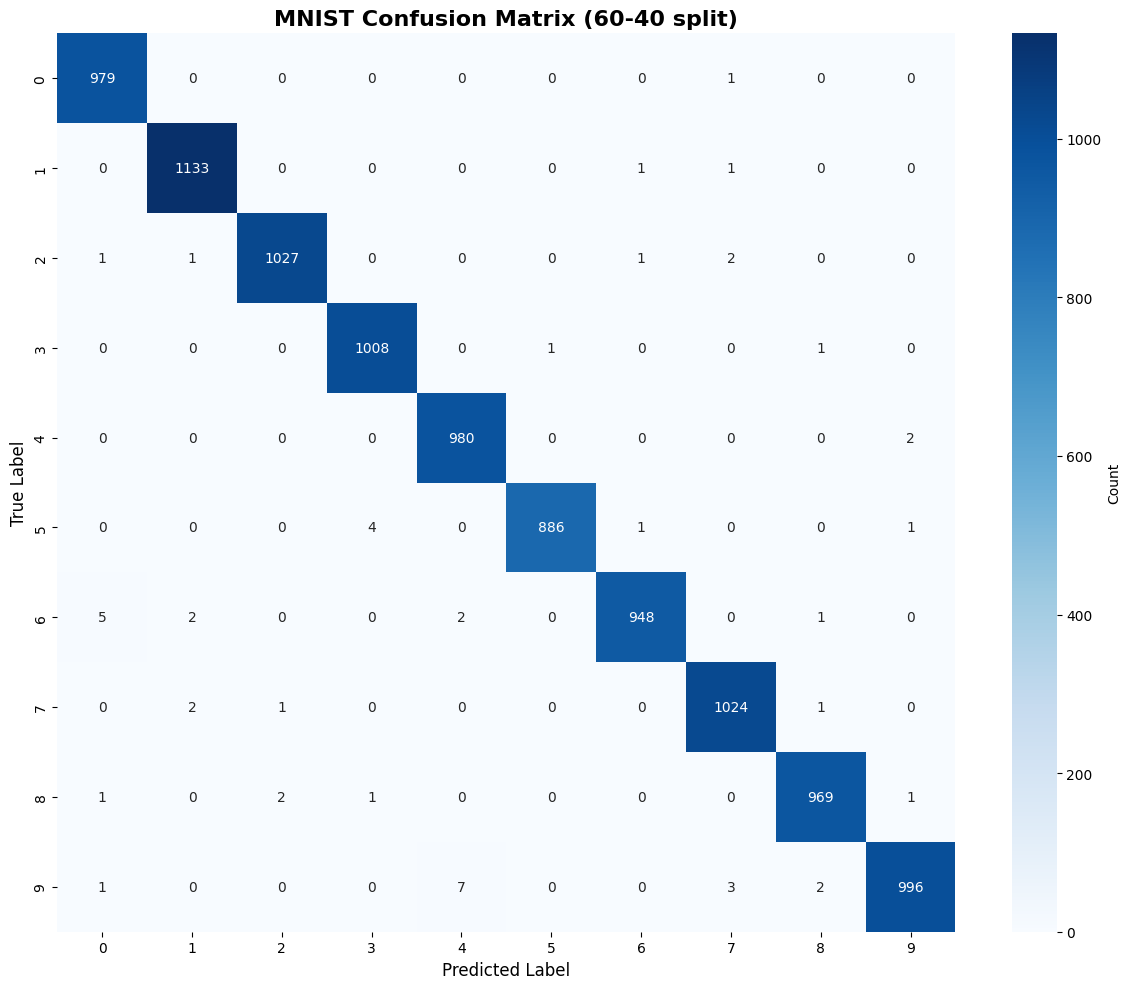

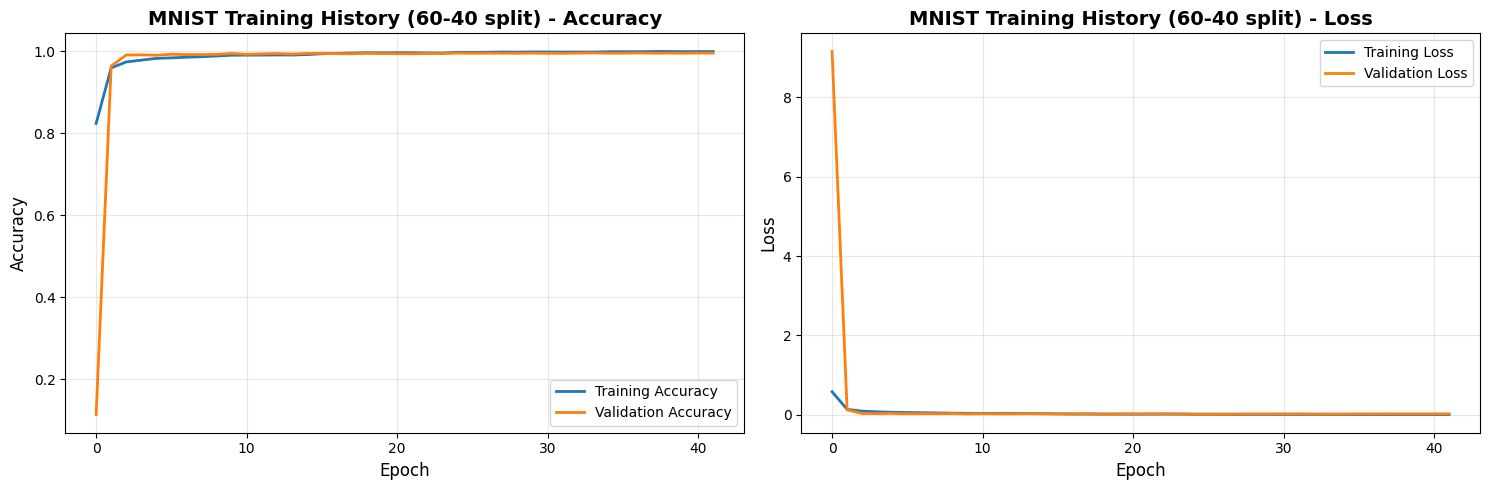

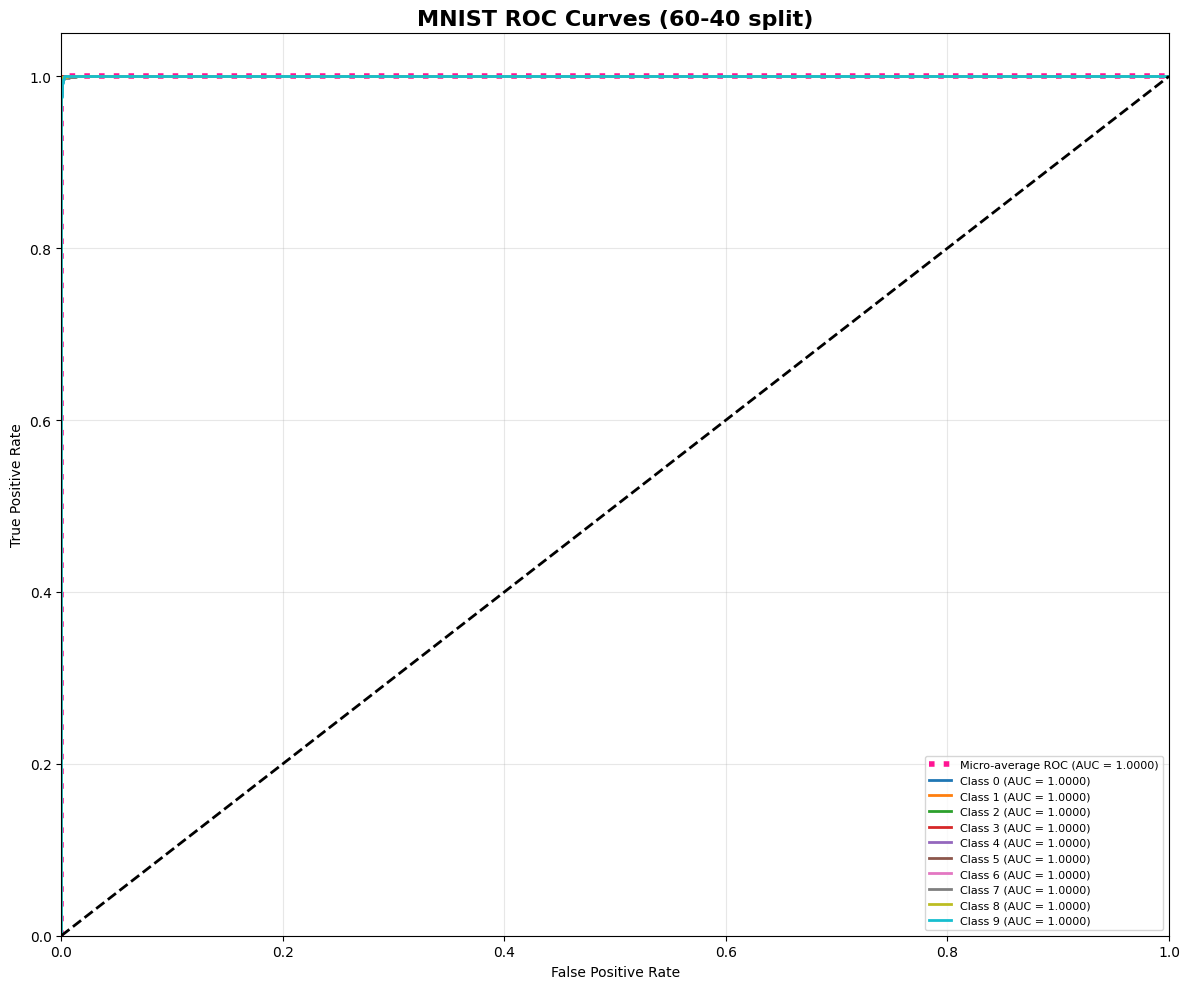

In [9]:
plot_confusion_matrix(best_mnist['y_true'], best_mnist['y_pred'],
                      mnist_classes, f"MNIST Confusion Matrix ({best_mnist['Split']} split)",
                      'mnist_confusion_matrix_best.png')

plot_training_history(best_mnist['History'],
                      f"MNIST Training History ({best_mnist['Split']} split)",
                      'mnist_training_curves_best.png')

mnist_auc = plot_roc_auc_multiclass(best_mnist['y_true'], best_mnist['y_pred_proba'],
                                    10, mnist_classes,
                                    f"MNIST ROC Curves ({best_mnist['Split']} split)",
                                    'mnist_roc_auc_best.png')


Trial 2

In [10]:

# ============================================================================
# PERFORMANCE COMPARISON TABLE
# ============================================================================

print("\n" + "="*80)
print("PERFORMANCE COMPARISON TABLE")
print("="*80)

# Create comparison dataframe
comparison_data = []

# Add CIFAR-10 results
for result in cifar10_results:
    comparison_data.append({
        'Dataset': 'CIFAR-10',
        'Split Ratio': result['Split'],
        'Train Samples': result['Train Size'],
        'Test Samples': result['Test Size'],
        'Test Accuracy (%)': f"{result['Test Accuracy']*100:.2f}",
        'Test Loss': f"{result['Test Loss']:.4f}",
        'Final Train Acc (%)': f"{result['History'].history['accuracy'][-1]*100:.2f}",
        'Final Val Acc (%)': f"{result['History'].history['val_accuracy'][-1]*100:.2f}"
    })

# Add MNIST results
for result in mnist_results:
    comparison_data.append({
        'Dataset': 'MNIST',
        'Split Ratio': result['Split'],
        'Train Samples': result['Train Size'],
        'Test Samples': result['Test Size'],
        'Test Accuracy (%)': f"{result['Test Accuracy']*100:.2f}",
        'Test Loss': f"{result['Test Loss']:.4f}",
        'Final Train Acc (%)': f"{result['History'].history['accuracy'][-1]*100:.2f}",
        'Final Val Acc (%)': f"{result['History'].history['val_accuracy'][-1]*100:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to 'model_comparison_results.csv'")



PERFORMANCE COMPARISON TABLE

  Dataset Split Ratio  Train Samples  Test Samples Test Accuracy (%) Test Loss Final Train Acc (%) Final Val Acc (%)
CIFAR-10       60-40          30000         10000             81.90    0.6279               96.58             83.50
CIFAR-10       70-30          35000         10000             82.58    0.5661               96.05             84.33
CIFAR-10       80-20          40000         10000             84.33    0.5318               96.12             85.16
   MNIST       60-40          36000         10000             99.50    0.0176               99.90             99.52
   MNIST       70-30          42000         10000             99.49    0.0164               99.86             99.47
   MNIST       80-20          48000         10000             99.48    0.0182               99.87             99.56

Results saved to 'model_comparison_results.csv'


In [11]:

# ============================================================================
# BEST MODELS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("BEST MODELS SUMMARY")
print("="*80)

best_models_summary = pd.DataFrame([
    {
        'Dataset': 'CIFAR-10',
        'Best Split': best_cifar10['Split'],
        'Test Accuracy (%)': f"{best_cifar10['Test Accuracy']*100:.2f}",
        'Test Loss': f"{best_cifar10['Test Loss']:.4f}",
        'AUC Score': f"{cifar10_auc:.4f}",
        'Train Samples': best_cifar10['Train Size'],
        'Test Samples': best_cifar10['Test Size']
    },
    {
        'Dataset': 'MNIST',
        'Best Split': best_mnist['Split'],
        'Test Accuracy (%)': f"{best_mnist['Test Accuracy']*100:.2f}",
        'Test Loss': f"{best_mnist['Test Loss']:.4f}",
        'AUC Score': f"{mnist_auc:.4f}",
        'Train Samples': best_mnist['Train Size'],
        'Test Samples': best_mnist['Test Size']
    }
])

print("\n", best_models_summary.to_string(index=False))



BEST MODELS SUMMARY

  Dataset Best Split Test Accuracy (%) Test Loss AUC Score  Train Samples  Test Samples
CIFAR-10      80-20             84.33    0.5318    0.9871          40000         10000
   MNIST      60-40             99.50    0.0176    1.0000          36000         10000


In [12]:

# ============================================================================
# CLASSIFICATION REPORTS
# ============================================================================

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

print("\n" + "-"*80)
print(f"CIFAR-10 Classification Report (Best Model - {best_cifar10['Split']} split)")
print("-"*80)
print(classification_report(best_cifar10['y_true'], best_cifar10['y_pred'],
                          target_names=cifar10_classes))

print("\n" + "-"*80)
print(f"MNIST Classification Report (Best Model - {best_mnist['Split']} split)")
print("-"*80)
print(classification_report(best_mnist['y_true'], best_mnist['y_pred'],
                          target_names=mnist_classes))

print("\n" + "="*80)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nGenerated Files:")
print("1. cifar10_confusion_matrix_best.png")
print("2. cifar10_training_curves_best.png")
print("3. cifar10_roc_auc_best.png")
print("4. mnist_confusion_matrix_best.png")
print("5. mnist_training_curves_best.png")
print("6. mnist_roc_auc_best.png")
print("7. model_comparison_results.csv")


DETAILED CLASSIFICATION REPORTS

--------------------------------------------------------------------------------
CIFAR-10 Classification Report (Best Model - 80-20 split)
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    airplane       0.87      0.84      0.86      1000
  automobile       0.94      0.90      0.92      1000
        bird       0.86      0.73      0.79      1000
         cat       0.69      0.70      0.70      1000
        deer       0.81      0.85      0.83      1000
         dog       0.75      0.78      0.76      1000
        frog       0.84      0.91      0.87      1000
       horse       0.91      0.86      0.89      1000
        ship       0.90      0.93      0.92      1000
       truck       0.88      0.92      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.8

In [3]:
!pip install scikit-plot tensorflow pandas seaborn 

   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.3 MB 19.1 MB/s eta 0:00:01
   --------------- ------------------------ 4.5/11.3 MB 13.4 MB/s eta 0:00:01
   --------------------- ------------------ 6.0/11.3 MB 11.2 MB/s eta 0:00:01
   ------------------------ --------------- 6.8/11.3 MB 9.3 MB/s eta 0:00:01
   -------------------------- ------------- 7.6/11.3 MB 7.7 MB/s eta 0:00:01
   ---------------------------- ----------- 8.1/11.3 MB 7.0 MB/s eta 0:00:01
   ------------------------------ --------- 8.7/11.3 MB 6.5 MB/s eta 0:00:01
   -------------------------------- ------- 9.2/11.3 MB 5.6 MB/s eta 0:00:01
   --------------------------------- ------ 9.4/11.3 MB 5.3 MB/s eta 0:00:01
   ------------------------------------ --- 10.2/11.3 MB 4.9 MB/s eta 0:00:01
   ------------------------------------- -- 10.7/11.3 MB 4.7 MB/s eta 0:00:01
   -------------------------------------- - 11.0/11.3 MB 4.6 MB/s eta 0:00:01


## Training VGG16,AlexNet,GoogleNet,RNN on CIFAR-10 Dataset

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.20.0
GPU Available: []


In [ ]:

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def plot_training_history(history, title, filename):
    """Plot training and validation accuracy/loss curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_auc_multiclass(y_true, y_pred_proba, n_classes, class_names, title, filename):
    """Plot ROC curve and calculate AUC for multiclass classification"""
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot
    plt.figure(figsize=(12, 10))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(min(n_classes, 10)):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return roc_auc["micro"]

In [ ]:
# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

def create_vgg16_model(input_shape=(32, 32, 3), num_classes=10):
    """Create VGG16-inspired model (adapted for small images)"""
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 4
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def create_alexnet_model(input_shape=(32, 32, 3), num_classes=10):
    """Create AlexNet-inspired model (adapted for small images)"""
    model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(96, (3, 3), strides=(1, 1), activation='relu',
                     padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # Second convolutional layer
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # Third, fourth, and fifth convolutional layers
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def inception_module(x, filters):
    """Inception module for GoogLeNet"""
    # 1x1 conv
    conv1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv1 = layers.BatchNormalization()(conv1)

    # 1x1 conv -> 3x3 conv
    conv3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    # 1x1 conv -> 5x5 conv
    conv5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    # 3x3 max pooling -> 1x1 conv
    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)
    pool = layers.BatchNormalization()(pool)

    # Concatenate all
    output = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return output

def create_googlenet_model(input_shape=(32, 32, 3), num_classes=10):
    """Create GoogLeNet-inspired model (adapted for small images)"""
    input_layer = layers.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)
    return model

def create_rnn_model(input_shape=(32, 32, 3), num_classes=10):
    """Create RNN model for image classification"""
    model = models.Sequential([
        # Reshape image to sequence (treat rows as time steps)
        layers.Reshape((input_shape[0], input_shape[1] * input_shape[2]),
                      input_shape=input_shape),

        # LSTM layers
        layers.LSTM(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.LSTM(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.LSTM(64),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Dense layers
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [ ]:

# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_and_evaluate(X_train, X_test, y_train, y_test,
                       model_creator, model_name, dataset_name, split_ratio,
                       epochs=50, batch_size=128, use_augmentation=False):
    """Train and evaluate model"""

    print(f"\n{'='*80}")
    print(f"Training {model_name} on {dataset_name} with {split_ratio} split")
    print(f"{'='*80}")

    # Create model
    model = model_creator()

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print model summary
    print(f"\n{model_name} Architecture:")
    model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=15,
                                   restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=5, min_lr=1e-7, verbose=1)

    # Data augmentation for CIFAR-10
    if use_augmentation and dataset_name == 'CIFAR-10':
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
        )
        datagen.fit(X_train)

        print(f"\nTraining with data augmentation...")
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
    else:
        print(f"\nTraining started...")
        history = model.fit(X_train, y_train,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_data=(X_test, y_test),
                           callbacks=[early_stopping, reduce_lr],
                           verbose=1)

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    return model, history, y_true, y_pred, y_pred_proba, test_accuracy, test_loss


In [ ]:

# ============================================================================
# LOAD DATASETS
# ============================================================================

print("\n" + "="*80)
print("LOADING DATASETS")
print("="*80)

# Load CIFAR-10
(X_cifar_train_full, y_cifar_train_full), (X_cifar_test, y_cifar_test) = cifar10.load_data()
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Normalize CIFAR-10
X_cifar_train_full = X_cifar_train_full.astype('float32') / 255.0
X_cifar_test = X_cifar_test.astype('float32') / 255.0
y_cifar_train_full = y_cifar_train_full.flatten()
y_cifar_test = y_cifar_test.flatten()

print(f"CIFAR-10 loaded: Train {X_cifar_train_full.shape}, Test {X_cifar_test.shape}")

# Load MNIST
(X_mnist_train_full, y_mnist_train_full), (X_mnist_test, y_mnist_test) = mnist.load_data()
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Reshape and normalize MNIST
X_mnist_train_full = X_mnist_train_full.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_mnist_test = X_mnist_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

print(f"MNIST loaded: Train {X_mnist_train_full.shape}, Test {X_mnist_test.shape}")


LOADING DATASETS
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 863s 5us/step
CIFAR-10 loaded: Train (50000, 32, 32, 3), Test (10000, 32, 32, 3)
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST loaded: Train (60000, 28, 28, 1), Test (10000, 28, 28, 1)



CIFAR-10 EXPERIMENTS

TESTING VGG16 ON CIFAR-10

Training VGG16 on CIFAR-10 with 60-40 split

VGG16 Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 512)      │         2,04

 Total params: 8,966,986 (34.21 MB)

 Trainable params: 8,959,562 (34.18 MB)

 Non-trainable params: 7,424 (29.00 KB)


Training started...
Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms/step - accuracy: 0.2779 - loss: 2.4064 - val_accuracy: 0.1336 - val_loss: 3.4540 - learning_rate: 0.0010
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.5139 - loss: 1.4026 - val_accuracy: 0.3440 - val_loss: 1.9854 - learning_rate: 0.0010
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.6368 - loss: 1.0281 - val_accuracy: 0.6453 - val_loss: 1.0584 - learning_rate: 0.0010
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.7290 - loss: 0.7881 - val_accuracy: 0.6903 - val_loss: 0.8880 - learning_rate: 0.0010
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.7817 - loss: 0.6401 - val_accuracy: 0.7260 - val_loss: 0.8509 - learning_rate: 0.0010
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.8268 - loss: 0.5190 - val_accuracy: 0.7433 - val_loss: 0.8576 - learning_rate: 0.0010
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63m

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 4, 4, 512)      │         2,04

 Total params: 8,966,986 (34.21 MB)

 Trainable params: 8,959,562 (34.18 MB)

 Non-trainable params: 7,424 (29.00 KB)


Training started...
Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.2915 - loss: 2.3635 - val_accuracy: 0.1730 - val_loss: 2.6822 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.5510 - loss: 1.2884 - val_accuracy: 0.6271 - val_loss: 1.0635 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.6806 - loss: 0.9160 - val_accuracy: 0.7002 - val_loss: 0.8646 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.7423 - loss: 0.7530 - val_accuracy: 0.6457 - val_loss: 1.1510 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.7966 - loss: 0.5931 - val_accuracy: 0.5733 - val_loss: 1.8317 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.8295 - loss: 0.4936 - val_accuracy: 0.6294 - val_loss: 1.4259 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 63m

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 4, 4, 512)      │         2,04

 Total params: 8,966,986 (34.21 MB)

 Trainable params: 8,959,562 (34.18 MB)

 Non-trainable params: 7,424 (29.00 KB)


Training started...
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step - accuracy: 0.2932 - loss: 2.3380 - val_accuracy: 0.1149 - val_loss: 2.7833 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.5585 - loss: 1.2664 - val_accuracy: 0.6261 - val_loss: 1.1118 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.6927 - loss: 0.8933 - val_accuracy: 0.7254 - val_loss: 0.8562 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.7608 - loss: 0.6965 - val_accuracy: 0.7085 - val_loss: 0.9299 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.8085 - loss: 0.5626 - val_accuracy: 0.6548 - val_loss: 1.2164 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.8401 - loss: 0.4713 - val_accuracy: 0.7158 - val_loss: 1.0324 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms

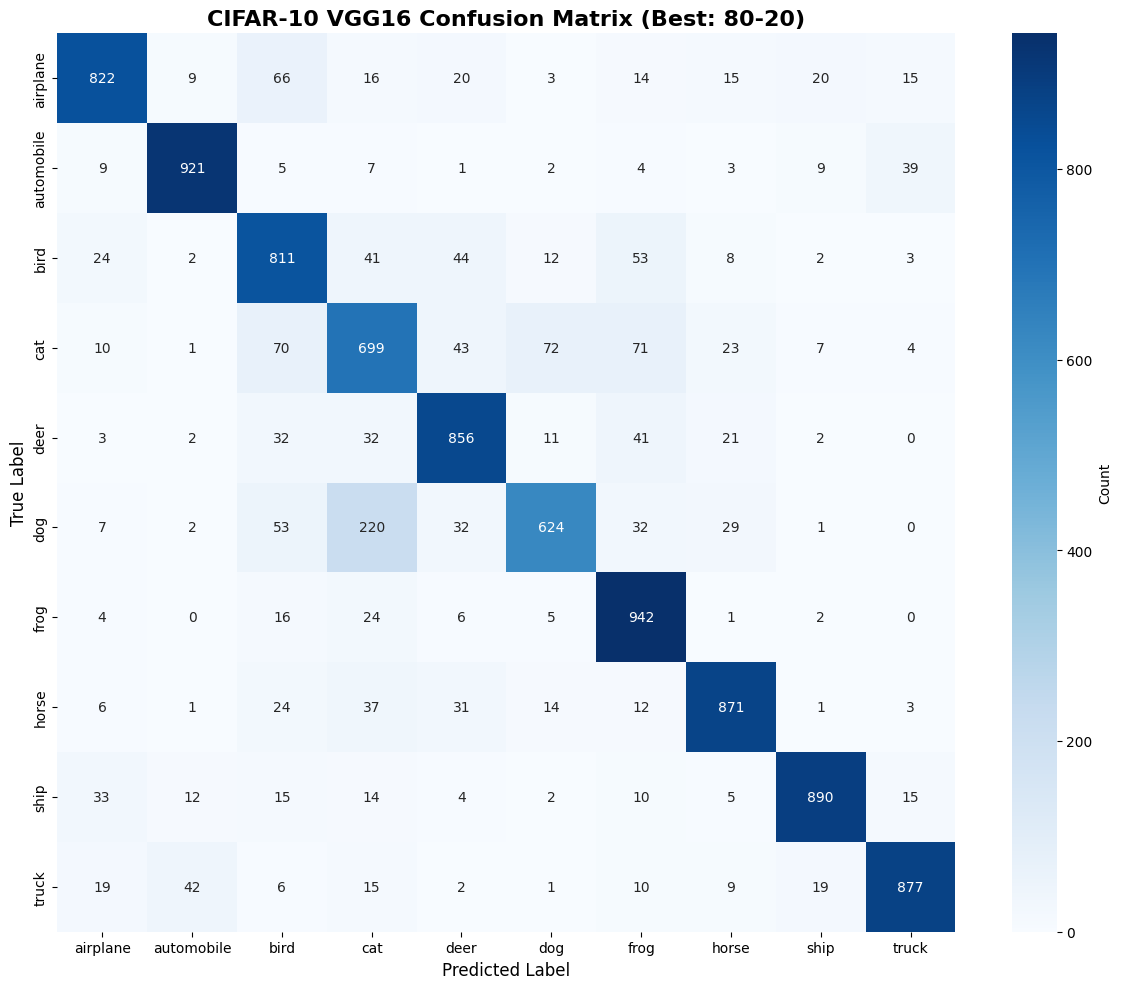

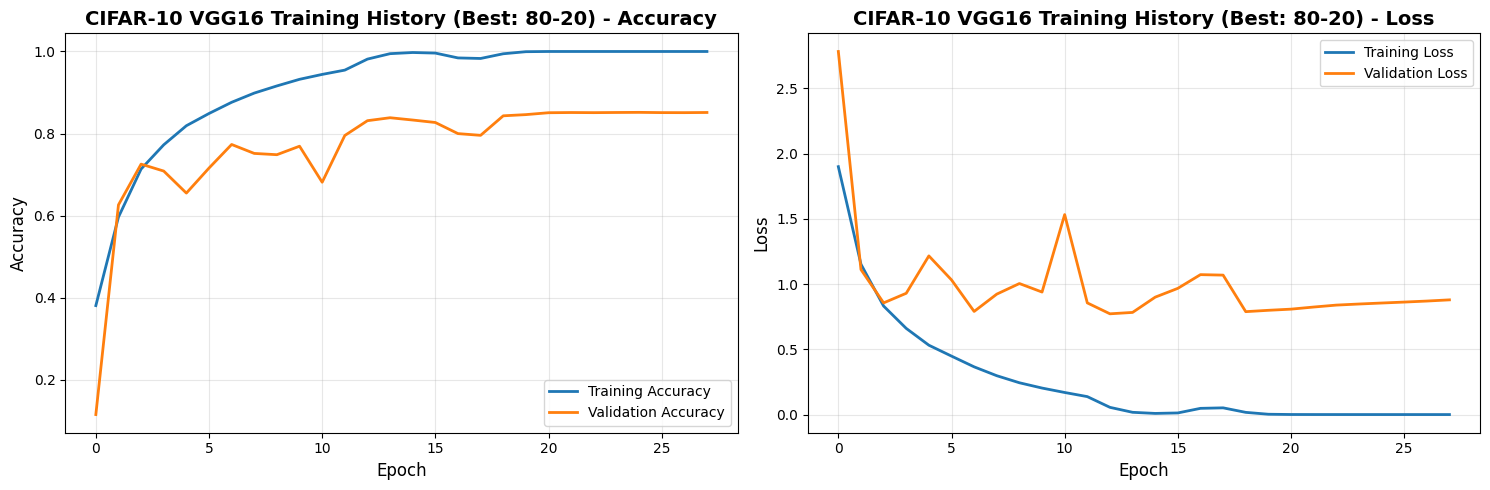

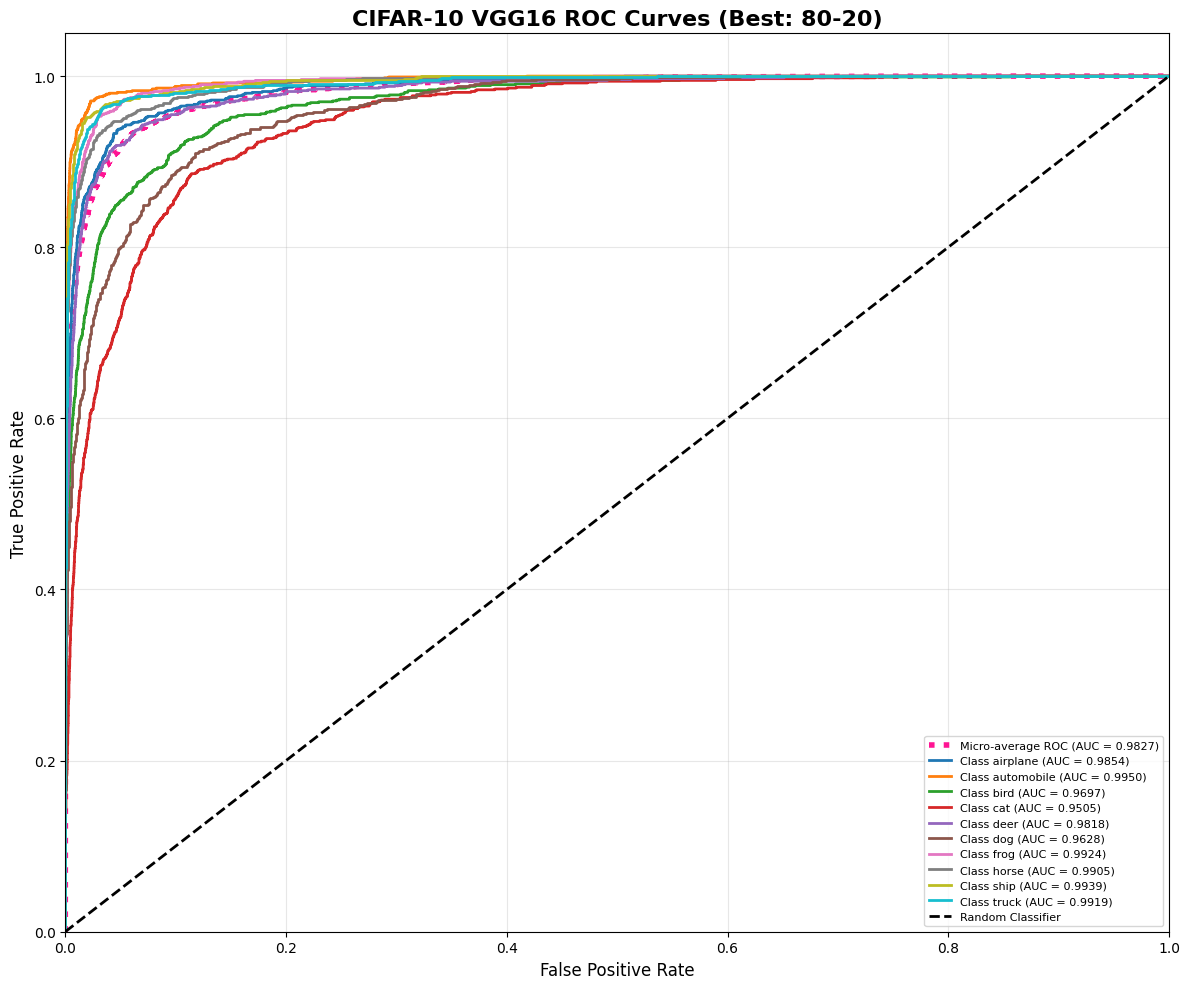


TESTING AlexNet ON CIFAR-10

Training AlexNet on CIFAR-10 with 60-40 split

AlexNet Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 36,963,594 (141.00 MB)

 Trainable params: 36,944,458 (140.93 MB)

 Non-trainable params: 19,136 (74.75 KB)


Training started...
Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.3359 - loss: 3.0104 - val_accuracy: 0.1440 - val_loss: 8.1656 - learning_rate: 0.0010
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.5277 - loss: 1.5941 - val_accuracy: 0.2319 - val_loss: 2.9276 - learning_rate: 0.0010
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.5918 - loss: 1.4257 - val_accuracy: 0.5558 - val_loss: 1.3971 - learning_rate: 0.0010
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.6655 - loss: 1.1595 - val_accuracy: 0.4751 - val_loss: 1.7574 - learning_rate: 0.0010
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.7044 - loss: 1.0265 - val_accuracy: 0.5106 - val_loss: 1.5939 - learning_rate: 0.0010
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.6965 - loss: 1.0291 - val_accuracy: 0.6295 - val_loss: 1.0574 - learning_rate: 0.0010
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 62m

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 16, 16, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 36,963,594 (141.00 MB)

 Trainable params: 36,944,458 (140.93 MB)

 Non-trainable params: 19,136 (74.75 KB)


Training started...
Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.3480 - loss: 2.8030 - val_accuracy: 0.1002 - val_loss: 29.3559 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.5598 - loss: 1.4134 - val_accuracy: 0.3717 - val_loss: 2.0961 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.6405 - loss: 1.1858 - val_accuracy: 0.4181 - val_loss: 2.6698 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.6839 - loss: 1.0297 - val_accuracy: 0.5094 - val_loss: 1.6000 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.7191 - loss: 0.9759 - val_accuracy: 0.3876 - val_loss: 3.0373 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.7561 - loss: 0.7803 - val_accuracy: 0.3258 - val_loss: 3.0428 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 60m

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 36,963,594 (141.00 MB)

 Trainable params: 36,944,458 (140.93 MB)

 Non-trainable params: 19,136 (74.75 KB)


Training started...
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.3591 - loss: 2.7351 - val_accuracy: 0.1622 - val_loss: 9.7625 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.5843 - loss: 1.4231 - val_accuracy: 0.5564 - val_loss: 1.3298 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.6609 - loss: 1.1473 - val_accuracy: 0.6184 - val_loss: 1.1826 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.7172 - loss: 0.9729 - val_accuracy: 0.6730 - val_loss: 0.9776 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.7606 - loss: 0.7847 - val_accuracy: 0.6002 - val_loss: 1.3467 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.7978 - loss: 0.6419 - val_accuracy: 0.7188 - val_loss: 0.8834 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms

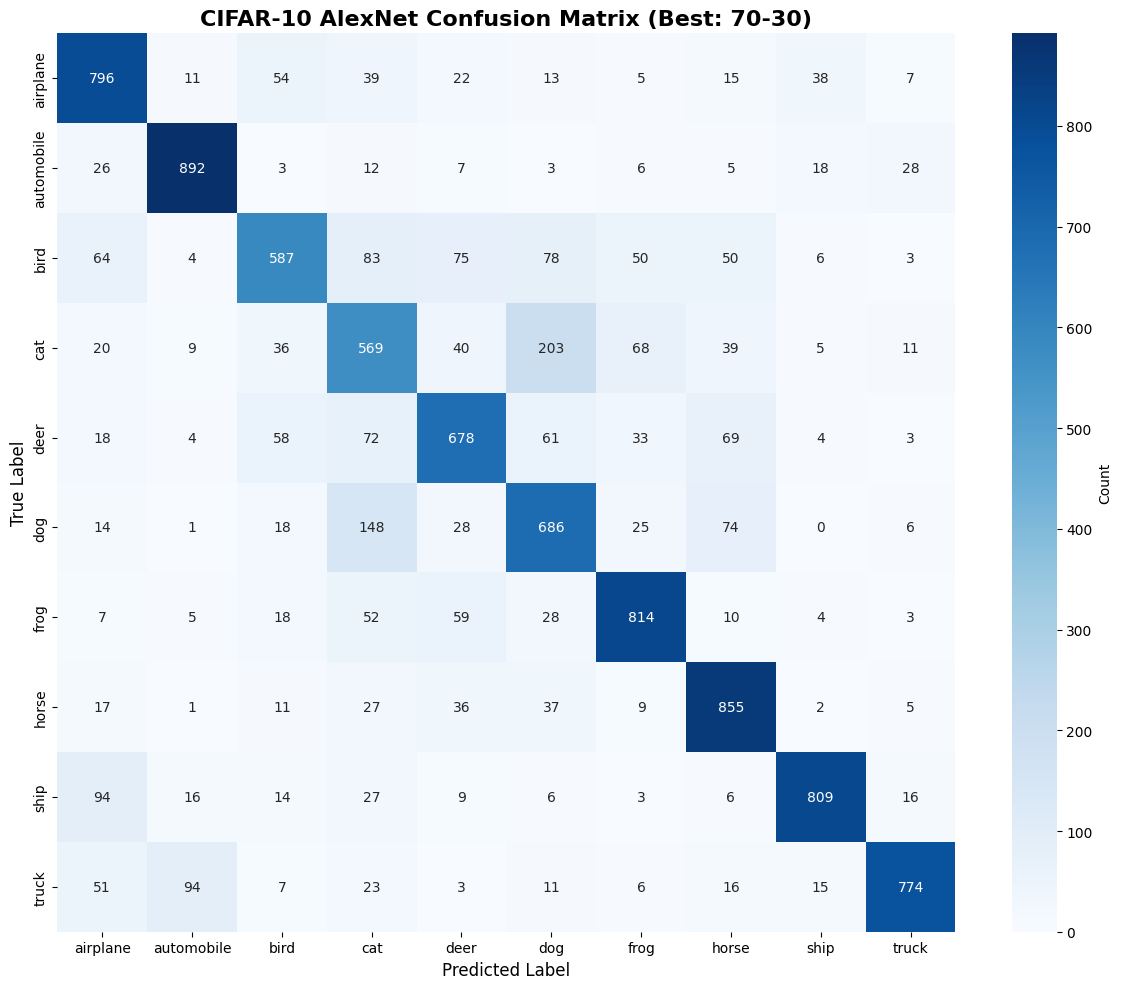

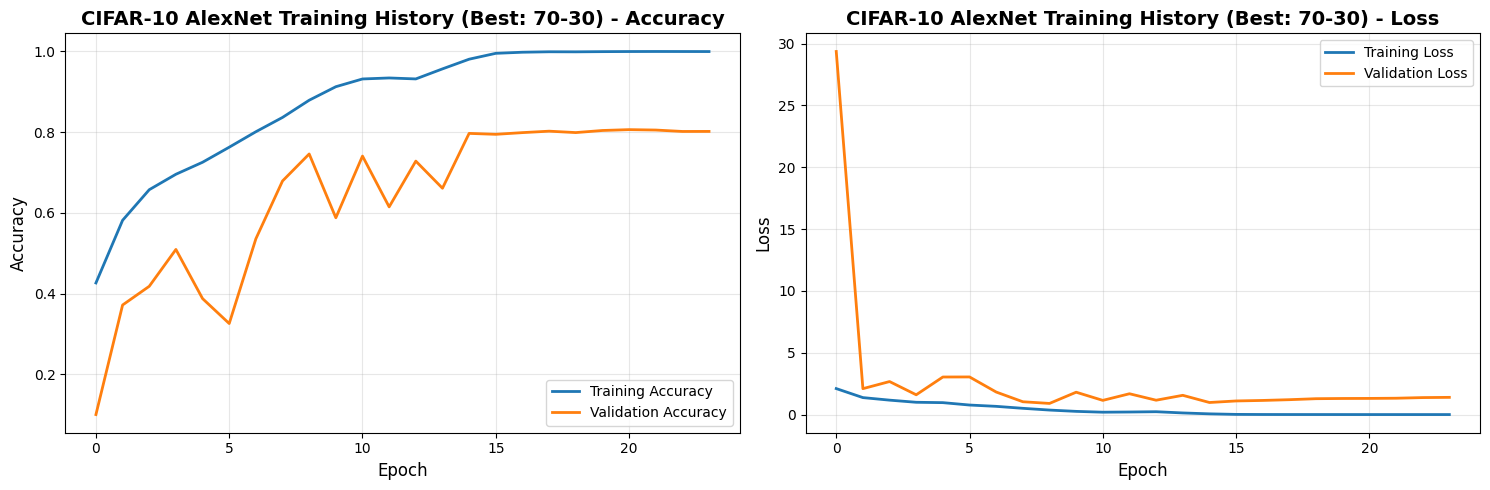

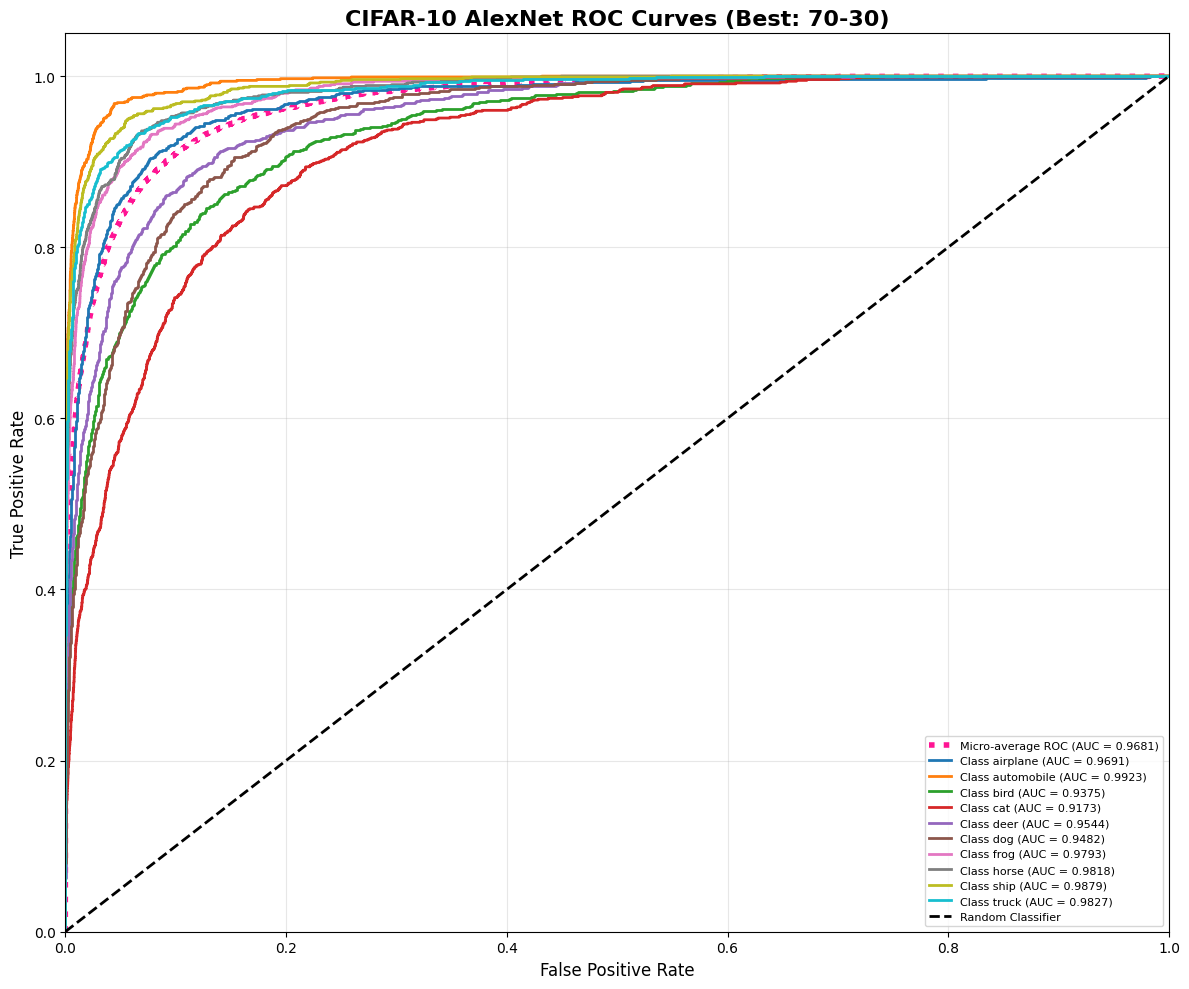


TESTING GoogLeNet ON CIFAR-10

Training GoogLeNet on CIFAR-10 with 60-40 split

GoogLeNet Architecture:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 16, 16,    │      6,240 │ max_pooling2d_21… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 16, 16,    │      1,040 │ max_pooling2d_21… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        384 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 16, 16,    │          0 │ max_pooling2d_21… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 16, 16,    │      4,160 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 16, 16,    │    110,720 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 16, 16,    │     12,832 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 16, 16,    │      2,080 │ max_pooling2d_22… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_51[0][0] 

 Total params: 2,233,874 (8.52 MB)

 Trainable params: 2,227,138 (8.50 MB)

 Non-trainable params: 6,736 (26.31 KB)


Training started...
Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 86s 196ms/step - accuracy: 0.4174 - loss: 1.6945 - val_accuracy: 0.1212 - val_loss: 6.2698 - learning_rate: 0.0010
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.6534 - loss: 0.9699 - val_accuracy: 0.4528 - val_loss: 1.7357 - learning_rate: 0.0010
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.7469 - loss: 0.7182 - val_accuracy: 0.6584 - val_loss: 0.9788 - learning_rate: 0.0010
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8063 - loss: 0.5625 - val_accuracy: 0.6324 - val_loss: 1.1920 - learning_rate: 0.0010
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.8478 - loss: 0.4380 - val_accuracy: 0.6006 - val_loss: 1.3050 - learning_rate: 0.0010
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.8741 - loss: 0.3554 - val_accuracy: 0.5977 - val_loss: 1.4095 - learning_rate: 0.0010
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 76m

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 16, 16,    │      6,240 │ max_pooling2d_29… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 16, 16,    │      1,040 │ max_pooling2d_29… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        384 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 16, 16,    │          0 │ max_pooling2d_29… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 16, 16,    │      4,160 │ max_pooling2d_29… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 16, 16,    │    110,720 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 16, 16,    │     12,832 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 16, 16,    │      2,080 │ max_pooling2d_30… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_81[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_82[0][0] 

 Total params: 2,233,874 (8.52 MB)

 Trainable params: 2,227,138 (8.50 MB)

 Non-trainable params: 6,736 (26.31 KB)


Training started...
Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 82s 173ms/step - accuracy: 0.4462 - loss: 1.6076 - val_accuracy: 0.1004 - val_loss: 6.5083 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.6783 - loss: 0.9093 - val_accuracy: 0.5568 - val_loss: 1.2406 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.7627 - loss: 0.6729 - val_accuracy: 0.6579 - val_loss: 1.0078 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.8170 - loss: 0.5255 - val_accuracy: 0.6347 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.8562 - loss: 0.4077 - val_accuracy: 0.4794 - val_loss: 1.7608 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.8824 - loss: 0.3313 - val_accuracy: 0.5654 - val_loss: 1.4316 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 75m

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 32, 32,    │      1,792 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_107[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_37    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 16, 16,    │      6,240 │ max_pooling2d_37… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 16, 16,    │      1,040 │ max_pooling2d_37… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        384 │ conv2d_109[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_111[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_38    │ (None, 16, 16,    │          0 │ max_pooling2d_37… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 16, 16,    │      4,160 │ max_pooling2d_37… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 16, 16,    │    110,720 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 16, 16,    │     12,832 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 16, 16,    │      2,080 │ max_pooling2d_38… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_108[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_110[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_112[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_113[0][0]

 Total params: 2,233,874 (8.52 MB)

 Trainable params: 2,227,138 (8.50 MB)

 Non-trainable params: 6,736 (26.31 KB)


Training started...
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 86s 162ms/step - accuracy: 0.4451 - loss: 1.6120 - val_accuracy: 0.1208 - val_loss: 5.9190 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.6932 - loss: 0.8742 - val_accuracy: 0.6484 - val_loss: 1.0474 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.7816 - loss: 0.6332 - val_accuracy: 0.7316 - val_loss: 0.7825 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.8294 - loss: 0.4961 - val_accuracy: 0.6634 - val_loss: 1.0753 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.8645 - loss: 0.3898 - val_accuracy: 0.6723 - val_loss: 1.0791 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.8917 - loss: 0.3093 - val_accuracy: 0.6770 - val_loss: 1.1309 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76m

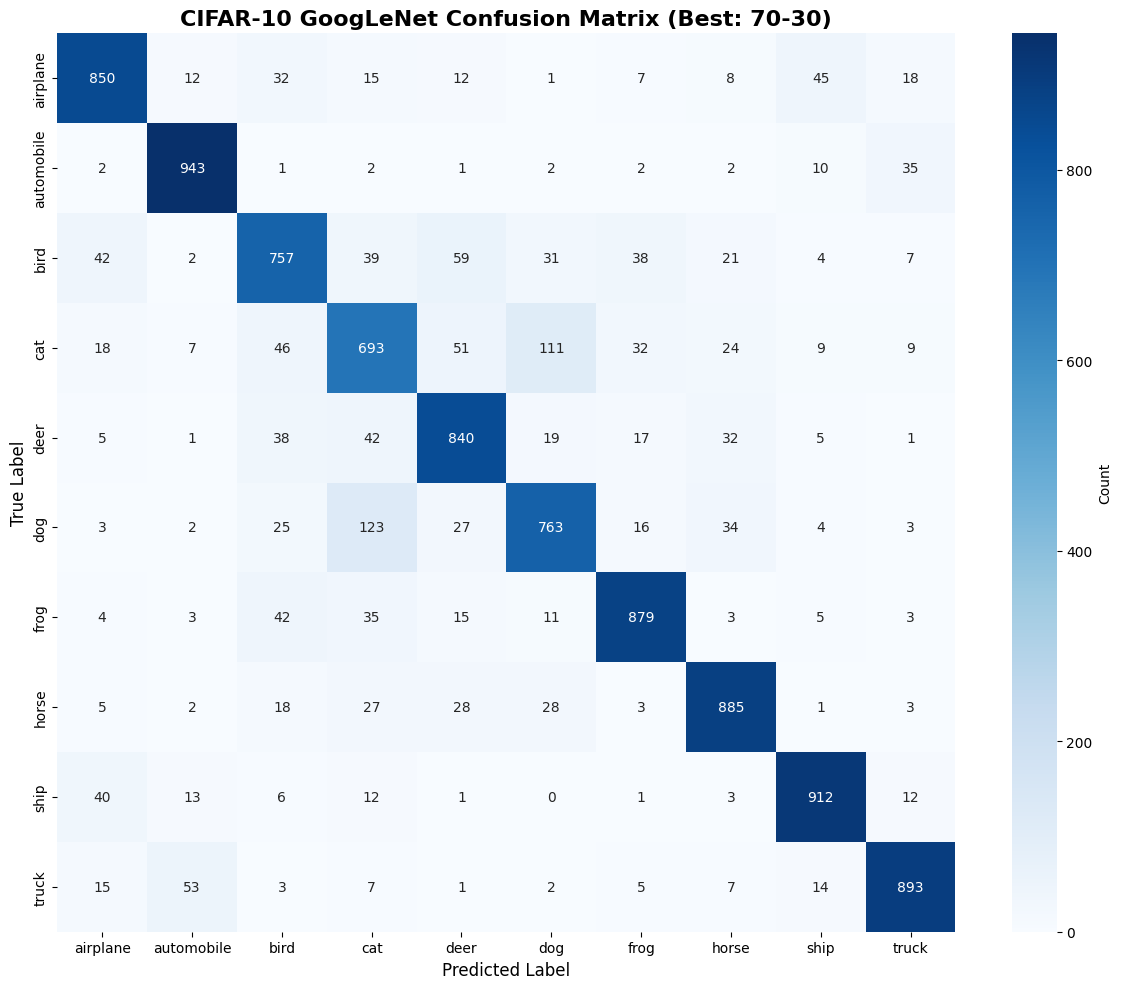

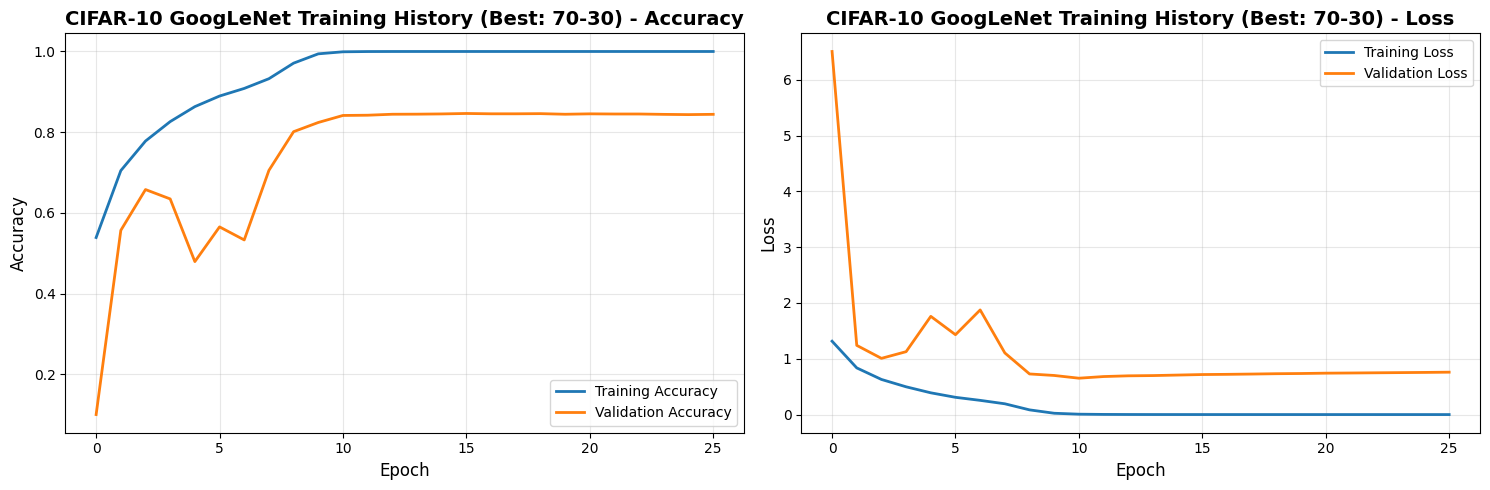

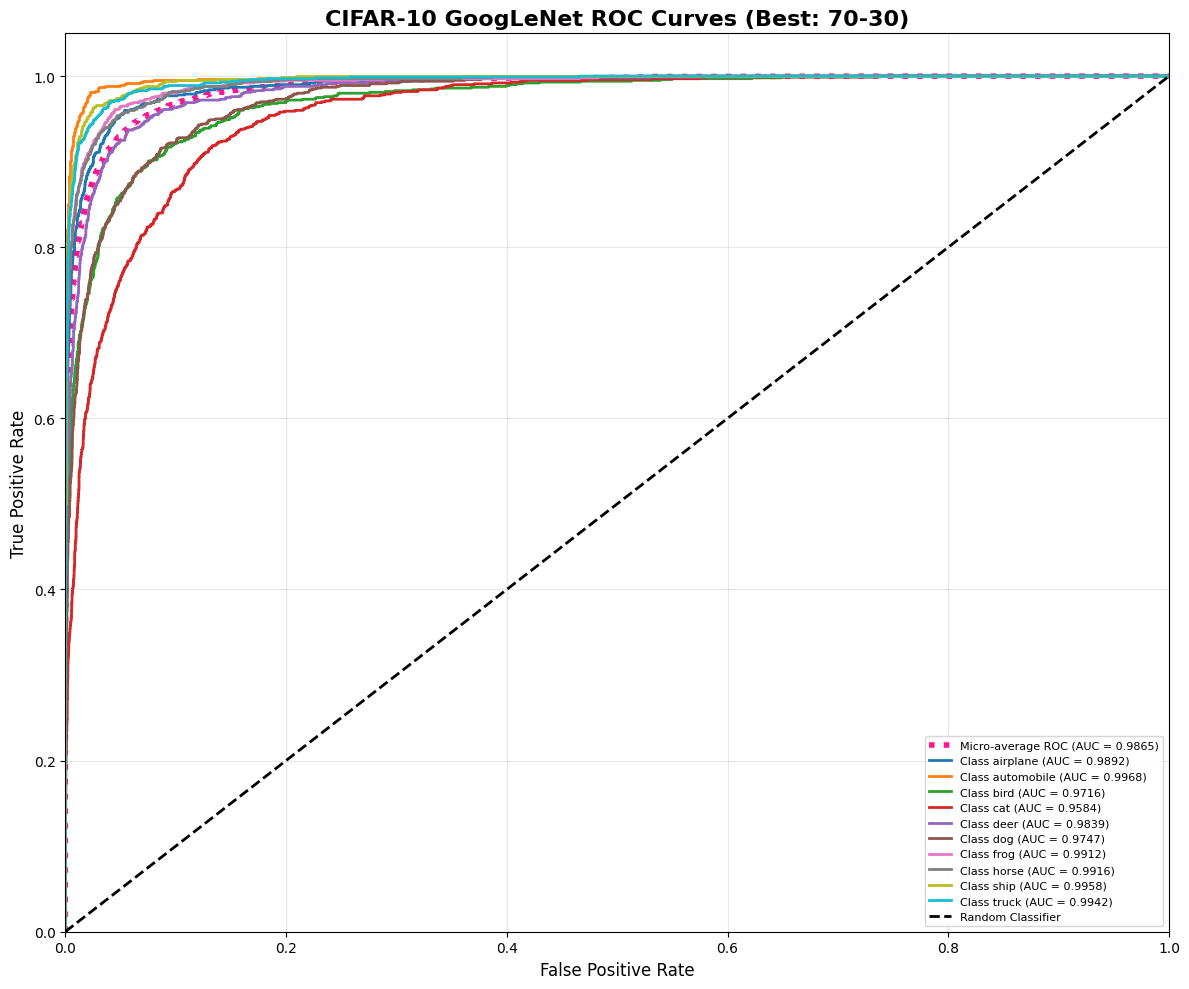


TESTING RNN ON CIFAR-10

Training RNN on CIFAR-10 with 60-40 split

RNN Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 32, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32, 128)        │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_150         │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_151         │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_152         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_153         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 317,706 (1.21 MB)

 Trainable params: 316,554 (1.21 MB)

 Non-trainable params: 1,152 (4.50 KB)


Training started...
Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.2037 - loss: 2.7287 - val_accuracy: 0.2362 - val_loss: 2.0757 - learning_rate: 0.0010
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3044 - loss: 1.9415 - val_accuracy: 0.3358 - val_loss: 1.8464 - learning_rate: 0.0010
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3708 - loss: 1.7431 - val_accuracy: 0.3390 - val_loss: 1.9303 - learning_rate: 0.0010
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4081 - loss: 1.6200 - val_accuracy: 0.4295 - val_loss: 1.6294 - learning_rate: 0.0010
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4438 - loss: 1.5346 - val_accuracy: 0.4458 - val_loss: 1.5282 - learning_rate: 0.0010
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4742 - loss: 1.4568 - val_accuracy: 0.4479 - val_loss: 1.5386 - learning_rate: 0.0010
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accur

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 32, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32, 128)        │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_154         │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_155         │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_156         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_157         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 317,706 (1.21 MB)

 Trainable params: 316,554 (1.21 MB)

 Non-trainable params: 1,152 (4.50 KB)


Training started...
Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.1955 - loss: 2.7007 - val_accuracy: 0.2601 - val_loss: 1.9504 - learning_rate: 0.0010
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3071 - loss: 1.9404 - val_accuracy: 0.3887 - val_loss: 1.6829 - learning_rate: 0.0010
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3761 - loss: 1.6988 - val_accuracy: 0.3850 - val_loss: 1.6906 - learning_rate: 0.0010
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4243 - loss: 1.5817 - val_accuracy: 0.3393 - val_loss: 1.8836 - learning_rate: 0.0010
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4594 - loss: 1.4967 - val_accuracy: 0.4031 - val_loss: 1.6845 - learning_rate: 0.0010
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4851 - loss: 1.4255 - val_accuracy: 0.4670 - val_loss: 1.5071 - learning_rate: 0.0010
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accur

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 32, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32, 128)        │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_158         │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_159         │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_160         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_161         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 317,706 (1.21 MB)

 Trainable params: 316,554 (1.21 MB)

 Non-trainable params: 1,152 (4.50 KB)


Training started...
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.2058 - loss: 2.6463 - val_accuracy: 0.2785 - val_loss: 1.9662 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3226 - loss: 1.8763 - val_accuracy: 0.3421 - val_loss: 1.8156 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3899 - loss: 1.6717 - val_accuracy: 0.4170 - val_loss: 1.6327 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4363 - loss: 1.5515 - val_accuracy: 0.4563 - val_loss: 1.4816 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4685 - loss: 1.4720 - val_accuracy: 0.4648 - val_loss: 1.4730 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4971 - loss: 1.3932 - val_accuracy: 0.4943 - val_loss: 1.3973 - learning_rate: 0.0010
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accu

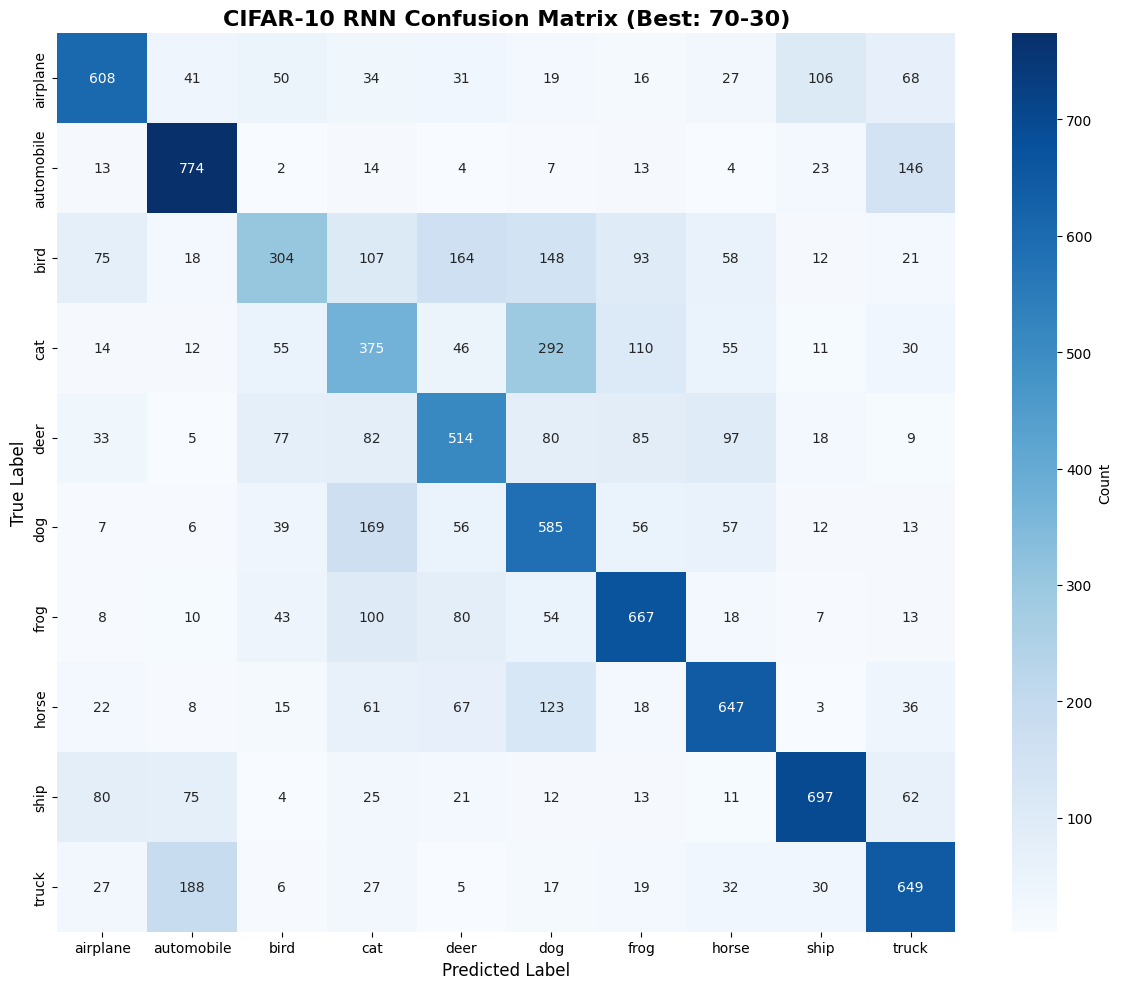

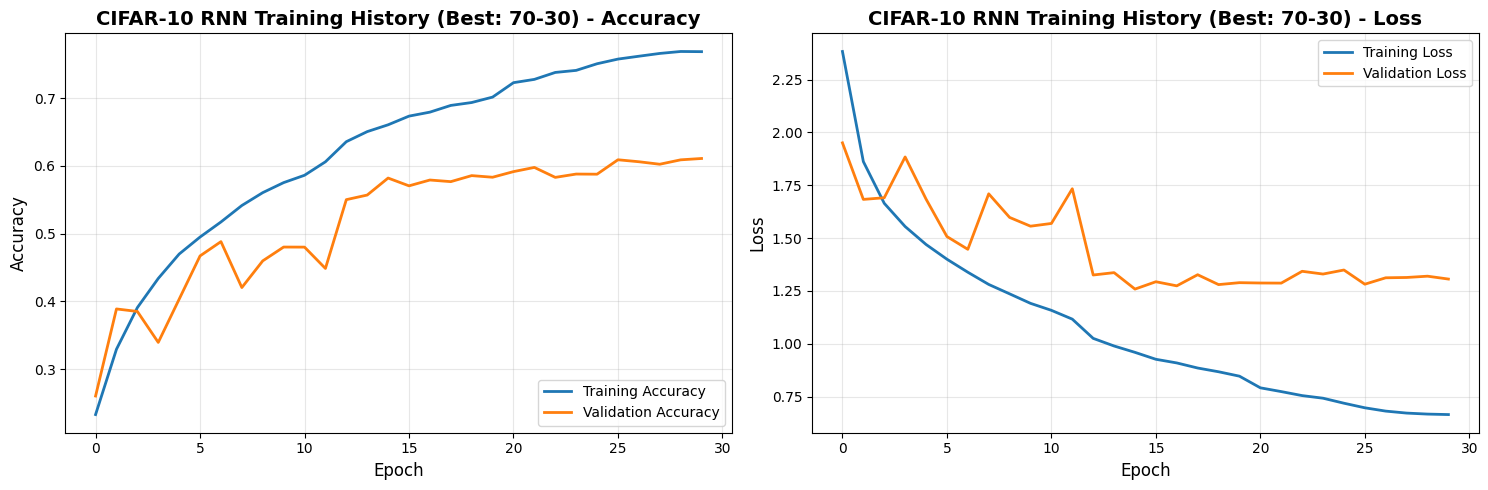

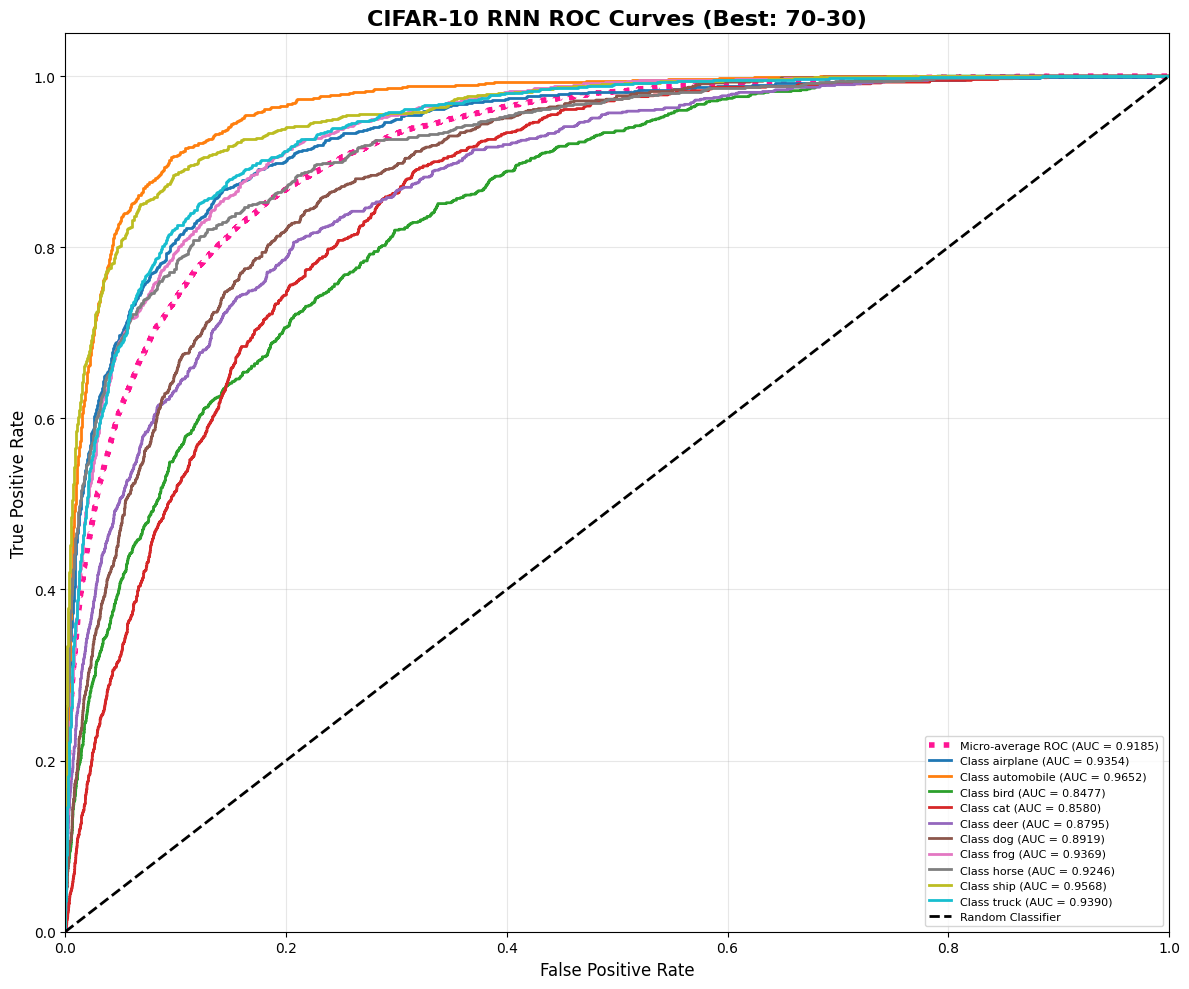

In [ ]:

# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================

# Models to test
models_config = {
    'VGG16': create_vgg16_model,
    'AlexNet': create_alexnet_model,
    'GoogLeNet': create_googlenet_model,
    'RNN': create_rnn_model
}

# Train-test split ratios
split_ratios = [0.6, 0.7, 0.8]

# Store all results
all_results = []

# ============================================================================
# CIFAR-10 EXPERIMENTS
# ============================================================================

print("\n" + "="*80)
print("CIFAR-10 EXPERIMENTS")
print("="*80)

for model_name, model_creator in models_config.items():
    print(f"\n{'='*80}")
    print(f"TESTING {model_name} ON CIFAR-10")
    print(f"{'='*80}")

    model_results = []

    for split_ratio in split_ratios:
        # Create train-validation split
        X_train, X_val, y_train, y_val = train_test_split(
            X_cifar_train_full, y_cifar_train_full,
            train_size=split_ratio, random_state=42, stratify=y_cifar_train_full
        )

        # Convert labels to categorical
        y_train_cat = to_categorical(y_train, 10)
        y_val_cat = to_categorical(y_val, 10)
        y_test_cat = to_categorical(y_cifar_test, 10)

        # Adjust model input shape for CIFAR-10
        if model_name == 'RNN':
            model_func = lambda: model_creator(input_shape=(32, 32, 3), num_classes=10)
        else:
            model_func = lambda: model_creator(input_shape=(32, 32, 3), num_classes=10)

        # Adjust epochs based on model type
        epochs = 50 if model_name == 'RNN' else 100

        # Train model
        try:
            model, history, y_true, y_pred, y_pred_proba, test_acc, test_loss = train_and_evaluate(
                X_train, X_cifar_test, y_train_cat, y_test_cat,
                model_func,
                model_name,
                'CIFAR-10',
                f"{int(split_ratio*100)}-{round((1-split_ratio)*100)}",
                epochs=epochs,
                batch_size=128,
                use_augmentation=False
            )

            # Store results
            model_results.append({
                'Dataset': 'CIFAR-10',
                'Model': model_name,
                'Split': f"{int(split_ratio*100)}-{round((1-split_ratio)*100)}",
                'Train Size': len(X_train),
                'Test Size': len(X_cifar_test),
                'Test Accuracy': test_acc,
                'Test Loss': test_loss,
                'model_obj': model,
                'History': history,
                'y_true': y_true,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            })

        except Exception as e:
            print(f"Error training {model_name} with split {split_ratio}: {str(e)}")
            continue

    # Find best result for this model on CIFAR-10
    if model_results:
        best_result = max(model_results, key=lambda x: x['Test Accuracy'])
        all_results.extend(model_results)

        # Generate visualizations for best case
        print(f"\nGenerating visualizations for best {model_name} on CIFAR-10...")

        # Confusion Matrix
        plot_confusion_matrix(
            best_result['y_true'],
            best_result['y_pred'],
            cifar10_classes,
            f"CIFAR-10 {model_name} Confusion Matrix (Best: {best_result['Split']})",
            f'cifar10_{model_name.lower()}_confusion_matrix.png'
        )

        # Training curves
        plot_training_history(
            best_result['History'],
            f"CIFAR-10 {model_name} Training History (Best: {best_result['Split']})",
            f'cifar10_{model_name.lower()}_training_curves.png'
        )

        # ROC-AUC
        auc_score = plot_roc_auc_multiclass(
            best_result['y_true'],
            best_result['y_pred_proba'],
            10,
            cifar10_classes,
            f"CIFAR-10 {model_name} ROC Curves (Best: {best_result['Split']})",
            f'cifar10_{model_name.lower()}_roc_auc.png'
        )

        best_result['AUC'] = auc_score


In [ ]:

# ============================================================================
# COMPREHENSIVE RESULTS TABLE
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS TABLE")
print("="*80)

# Create results dataframe
results_data = []
for result in all_results:
    results_data.append({
        'Dataset': result['Dataset'],
        'Model': result['Model'],
        'Split Ratio': result['Split'],
        'Train Samples': result['Train Size'],
        'Test Samples': result['Test Size'],
        'Test Accuracy (%)': f"{result['Test Accuracy']*100:.2f}",
        'Test Loss': f"{result['Test Loss']:.4f}",
        'Final Train Acc (%)': f"{result['History'].history['accuracy'][-1]*100:.2f}",
        'Final Val Acc (%)': f"{result['History'].history['val_accuracy'][-1]*100:.2f}"
    })

results_df = pd.DataFrame(results_data)
print("\n", results_df.to_string(index=False))

# Save results
results_df.to_csv('all_models_comparison_results.csv', index=False)
print("\nResults saved to 'all_models_comparison_results.csv'")

In [ ]:

# ============================================================================
# BEST MODELS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("BEST MODELS SUMMARY (BY DATASET)")
print("="*80)

# Find best model for each dataset
best_models_summary = []

for dataset in ['CIFAR-10', 'MNIST']:
    dataset_results = [r for r in all_results if r['Dataset'] == dataset]
    if dataset_results:
        best = max(dataset_results, key=lambda x: x['Test Accuracy'])
        best_models_summary.append({
            'Dataset': dataset,
            'Best Model': best['Model'],
            'Split': best['Split'],
            'Test Accuracy (%)': f"{best['Test Accuracy']*100:.2f}",
            'Test Loss': f"{best['Test Loss']:.4f}",
            'AUC Score': f"{best.get('AUC', 0):.4f}",
            'Train Samples': best['Train Size']
        })

best_summary_df = pd.DataFrame(best_models_summary)
print("\n", best_summary_df.to_string(index=False))

In [1]:
!pip install scikit-plot tensorflow

## Training Vgg16, alexnet, googlenet and RNN on MNIST dataset

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def plot_training_history(history, title, filename):
    """Plot training and validation accuracy/loss curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_auc_multiclass(y_true, y_pred_proba, n_classes, class_names, title, filename):
    """Plot ROC curve and calculate AUC for multiclass classification"""
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot
    plt.figure(figsize=(12, 10))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(min(n_classes, 10)):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return roc_auc["micro"]

In [5]:
# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

def create_vgg16_model(input_shape=(32, 32, 3), num_classes=10):
    """Create VGG16-inspired model (adapted for small images)"""
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 4
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def create_alexnet_model(input_shape=(32, 32, 3), num_classes=10):
    """Create AlexNet-inspired model (adapted for small images)"""
    model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(96, (3, 3), strides=(1, 1), activation='relu',
                     padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # Second convolutional layer
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # Third, fourth, and fifth convolutional layers
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def inception_module(x, filters):
    """Inception module for GoogLeNet"""
    # 1x1 conv
    conv1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv1 = layers.BatchNormalization()(conv1)

    # 1x1 conv -> 3x3 conv
    conv3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    # 1x1 conv -> 5x5 conv
    conv5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    # 3x3 max pooling -> 1x1 conv
    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)
    pool = layers.BatchNormalization()(pool)

    # Concatenate all
    output = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return output

def create_googlenet_model(input_shape=(32, 32, 3), num_classes=10):
    """Create GoogLeNet-inspired model (adapted for small images)"""
    input_layer = layers.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)
    return model

def create_rnn_model(input_shape=(32, 32, 3), num_classes=10):
    """Create RNN model for image classification"""
    model = models.Sequential([
        # Reshape image to sequence (treat rows as time steps)
        layers.Reshape((input_shape[0], input_shape[1] * input_shape[2]),
                      input_shape=input_shape),

        # LSTM layers
        layers.LSTM(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.LSTM(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.LSTM(64),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Dense layers
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [6]:

# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_and_evaluate(X_train, X_test, y_train, y_test,
                       model_creator, model_name, dataset_name, split_ratio,
                       epochs=50, batch_size=128, use_augmentation=False):
    """Train and evaluate model"""

    print(f"\n{'='*80}")
    print(f"Training {model_name} on {dataset_name} with {split_ratio} split")
    print(f"{'='*80}")

    # Create model
    model = model_creator()

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print model summary
    print(f"\n{model_name} Architecture:")
    model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=15,
                                   restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=5, min_lr=1e-7, verbose=1)

    # Data augmentation for CIFAR-10
    if use_augmentation and dataset_name == 'CIFAR-10':
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
        )
        datagen.fit(X_train)

        print(f"\nTraining with data augmentation...")
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
    else:
        print(f"\nTraining started...")
        history = model.fit(X_train, y_train,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_data=(X_test, y_test),
                           callbacks=[early_stopping, reduce_lr],
                           verbose=1)

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    return model, history, y_true, y_pred, y_pred_proba, test_accuracy, test_loss


In [7]:

# ============================================================================
# LOAD DATASETS
# ============================================================================

print("\n" + "="*80)
print("LOADING DATASETS")
print("="*80)

# Load CIFAR-10
(X_cifar_train_full, y_cifar_train_full), (X_cifar_test, y_cifar_test) = cifar10.load_data()
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Normalize CIFAR-10
X_cifar_train_full = X_cifar_train_full.astype('float32') / 255.0
X_cifar_test = X_cifar_test.astype('float32') / 255.0
y_cifar_train_full = y_cifar_train_full.flatten()
y_cifar_test = y_cifar_test.flatten()

print(f"CIFAR-10 loaded: Train {X_cifar_train_full.shape}, Test {X_cifar_test.shape}")

# Load MNIST
(X_mnist_train_full, y_mnist_train_full), (X_mnist_test, y_mnist_test) = mnist.load_data()
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Reshape and normalize MNIST
X_mnist_train_full = X_mnist_train_full.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_mnist_test = X_mnist_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

print(f"MNIST loaded: Train {X_mnist_train_full.shape}, Test {X_mnist_test.shape}")


LOADING DATASETS
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
CIFAR-10 loaded: Train (50000, 32, 32, 3), Test (10000, 32, 32, 3)
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST loaded: Train (60000, 28, 28, 1), Test (10000, 28, 28, 1)


In [ ]:

# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================

# Models to test
models_config = {
    'VGG16': create_vgg16_model,
    'AlexNet': create_alexnet_model,
    'GoogLeNet': create_googlenet_model,
    'RNN': create_rnn_model
}

# Train-test split ratios
split_ratios = [0.6, 0.7, 0.8]

# Store all results
all_results = []


MNIST EXPERIMENTS

TESTING VGG16 ON MNIST

Training VGG16 on MNIST with 60-40 split

VGG16 Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 3, 3, 512)      │         2,04

 Total params: 8,179,402 (31.20 MB)

 Trainable params: 8,171,978 (31.17 MB)

 Non-trainable params: 7,424 (29.00 KB)


Training started...
Epoch 1/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 49s 96ms/step - accuracy: 0.8553 - loss: 0.5074 - val_accuracy: 0.1135 - val_loss: 10.2160 - learning_rate: 0.0010
Epoch 2/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.9783 - loss: 0.0725 - val_accuracy: 0.9490 - val_loss: 0.2157 - learning_rate: 0.0010
Epoch 3/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.9837 - loss: 0.0540 - val_accuracy: 0.9836 - val_loss: 0.0647 - learning_rate: 0.0010
Epoch 4/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9874 - loss: 0.0412 - val_accuracy: 0.9752 - val_loss: 0.1050 - learning_rate: 0.0010
Epoch 5/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9907 - loss: 0.0317 - val_accuracy: 0.9843 - val_loss: 0.0624 - learning_rate: 0.0010
Epoch 6/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9903 - loss: 0.0296 - val_accuracy: 0.9841 - val_loss: 0.0654 - learning_rate: 0.0010
Epoch 7/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 3, 3, 512)      │         2,04

 Total params: 8,179,402 (31.20 MB)

 Trainable params: 8,171,978 (31.17 MB)

 Non-trainable params: 7,424 (29.00 KB)


Training started...
Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - accuracy: 0.8602 - loss: 0.4690 - val_accuracy: 0.1135 - val_loss: 8.6191 - learning_rate: 0.0010
Epoch 2/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.9788 - loss: 0.0701 - val_accuracy: 0.9782 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9870 - loss: 0.0426 - val_accuracy: 0.9554 - val_loss: 0.1958 - learning_rate: 0.0010
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9857 - loss: 0.0489 - val_accuracy: 0.9831 - val_loss: 0.0673 - learning_rate: 0.0010
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9902 - loss: 0.0289 - val_accuracy: 0.9794 - val_loss: 0.0793 - learning_rate: 0.0010
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9937 - loss: 0.0203 - val_accuracy: 0.9771 - val_loss: 0.1053 - learning_rate: 0.0010
Epoch 7/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step -

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 3, 3, 512)      │         2,04

 Total params: 8,179,402 (31.20 MB)

 Trainable params: 8,171,978 (31.17 MB)

 Non-trainable params: 7,424 (29.00 KB)


Training started...
Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.8705 - loss: 0.4510 - val_accuracy: 0.1143 - val_loss: 7.5926 - learning_rate: 0.0010
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9807 - loss: 0.0658 - val_accuracy: 0.9862 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9871 - loss: 0.0443 - val_accuracy: 0.9907 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9904 - loss: 0.0326 - val_accuracy: 0.9735 - val_loss: 0.0882 - learning_rate: 0.0010
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9914 - loss: 0.0291 - val_accuracy: 0.9879 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9930 - loss: 0.0232 - val_accuracy: 0.9587 - val_loss: 0.1874 - learning_rate: 0.0010
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step -

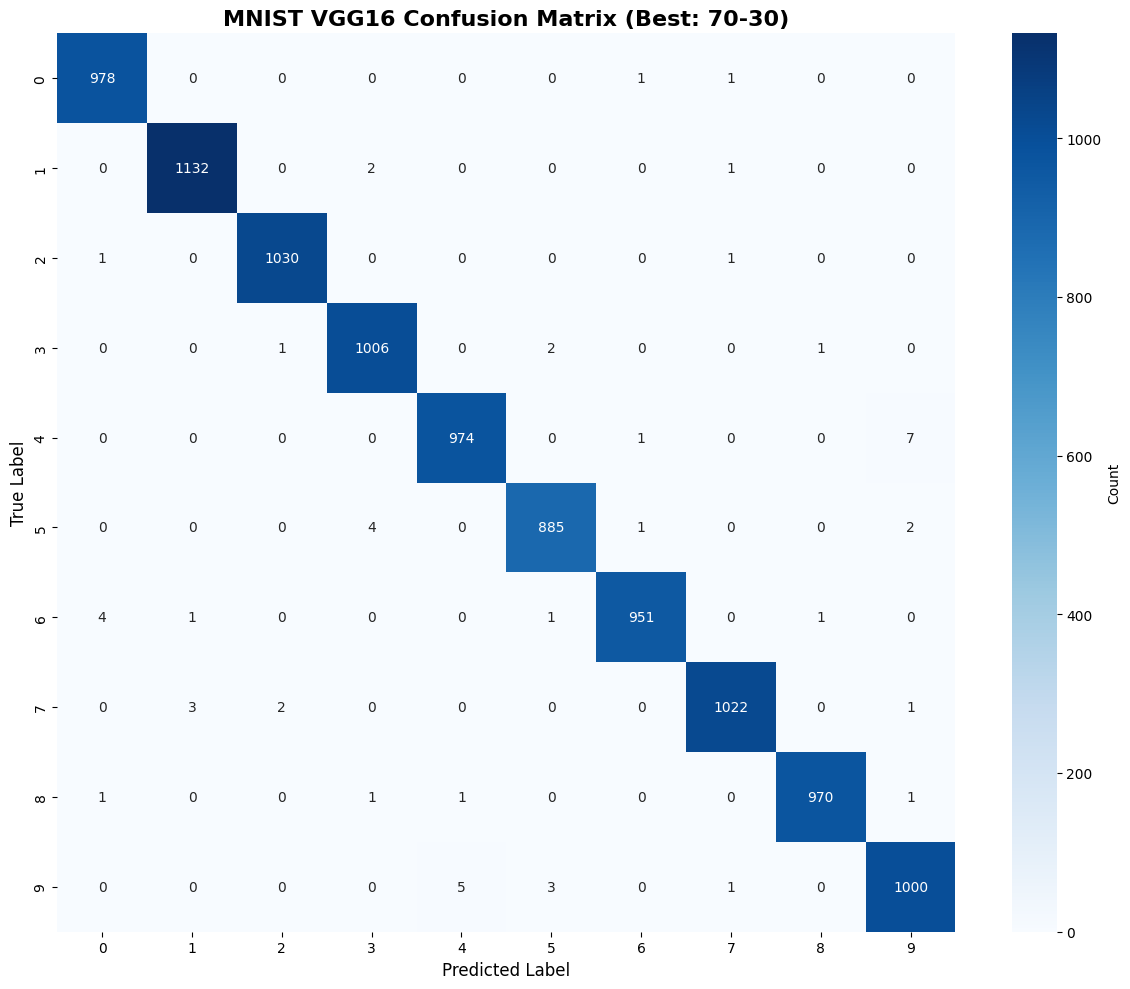

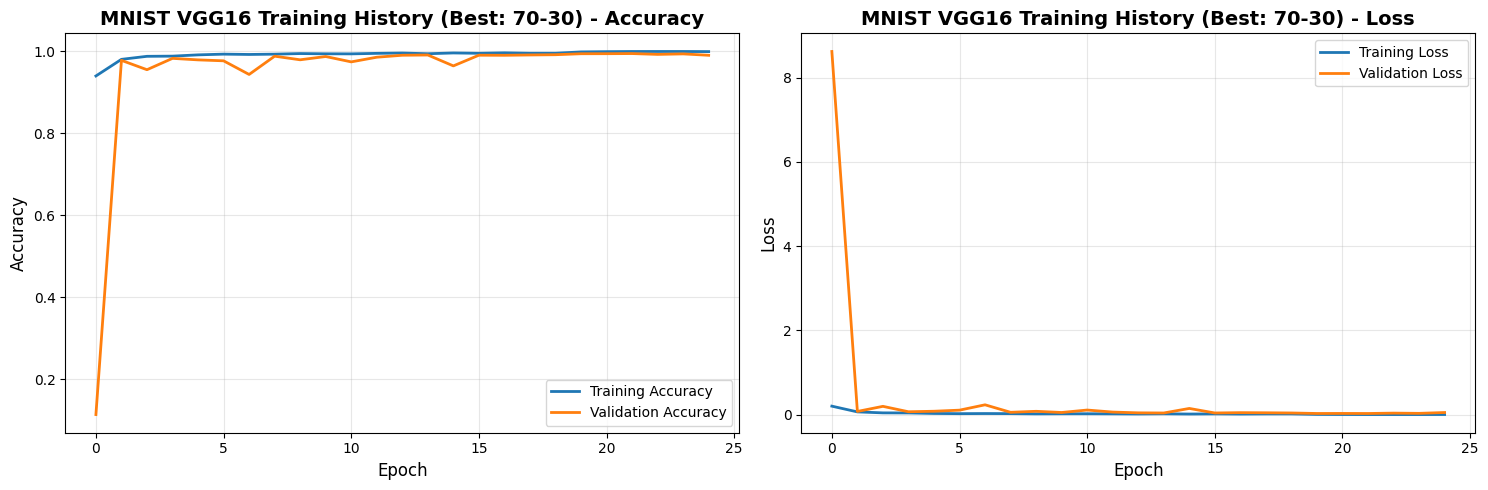

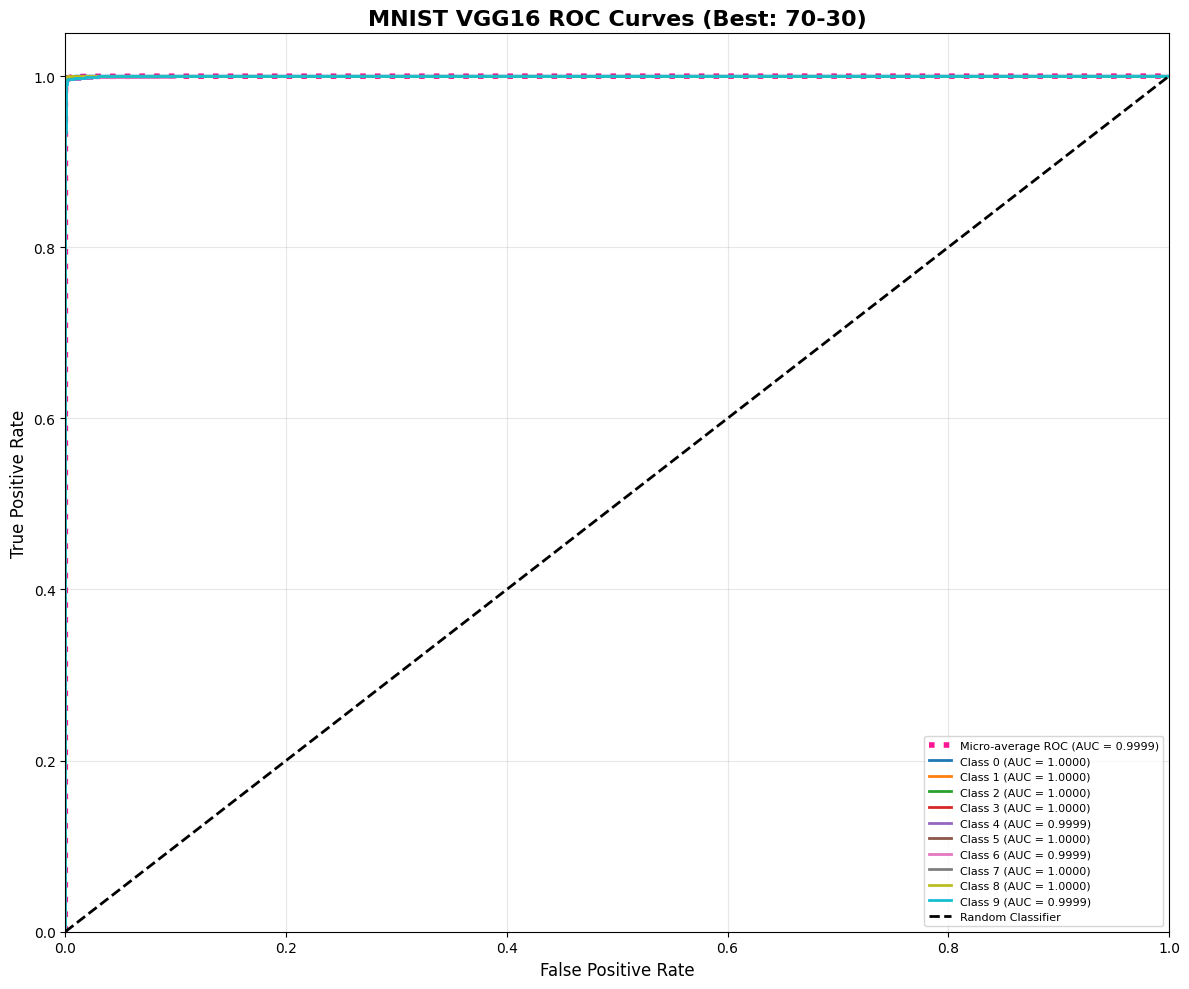


TESTING AlexNet ON MNIST

Training AlexNet on MNIST with 60-40 split

AlexNet Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 28, 28, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 28, 28, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 14, 14, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 7, 7, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 7, 7, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 7, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 7, 7, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 7, 7, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 29,621,834 (113.00 MB)

 Trainable params: 29,602,698 (112.93 MB)

 Non-trainable params: 19,136 (74.75 KB)


Training started...
Epoch 1/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.9017 - loss: 0.5050 - val_accuracy: 0.1135 - val_loss: 57.0209 - learning_rate: 0.0010
Epoch 2/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.9785 - loss: 0.0866 - val_accuracy: 0.8539 - val_loss: 0.9826 - learning_rate: 0.0010
Epoch 3/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9817 - loss: 0.0757 - val_accuracy: 0.9856 - val_loss: 0.0706 - learning_rate: 0.0010
Epoch 4/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.9887 - loss: 0.0402 - val_accuracy: 0.9742 - val_loss: 0.1207 - learning_rate: 0.0010
Epoch 5/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.9880 - loss: 0.0448 - val_accuracy: 0.9865 - val_loss: 0.0840 - learning_rate: 0.0010
Epoch 6/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.9892 - loss: 0.0457 - val_accuracy: 0.9805 - val_loss: 0.1222 - learning_rate: 0.0010
Epoch 7/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_65 (Conv2D)              │ (None, 28, 28, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 28, 28, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 14, 14, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 7, 7, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 7, 7, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 7, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 7, 7, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 7, 7, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 29,621,834 (113.00 MB)

 Trainable params: 29,602,698 (112.93 MB)

 Non-trainable params: 19,136 (74.75 KB)


Training started...
Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.9045 - loss: 0.4983 - val_accuracy: 0.1135 - val_loss: 32.4813 - learning_rate: 0.0010
Epoch 2/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9778 - loss: 0.0914 - val_accuracy: 0.9513 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9818 - loss: 0.0741 - val_accuracy: 0.9797 - val_loss: 0.1069 - learning_rate: 0.0010
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9876 - loss: 0.0507 - val_accuracy: 0.9771 - val_loss: 0.1295 - learning_rate: 0.0010
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9879 - loss: 0.0506 - val_accuracy: 0.9772 - val_loss: 0.1363 - learning_rate: 0.0010
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.9893 - loss: 0.0433 - val_accuracy: 0.9729 - val_loss: 0.1550 - learning_rate: 0.0010
Epoch 7/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)              │ (None, 28, 28, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 28, 28, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 14, 14, 256)    │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 7, 7, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 7, 7, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 7, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 7, 7, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 7, 7, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 29,621,834 (113.00 MB)

 Trainable params: 29,602,698 (112.93 MB)

 Non-trainable params: 19,136 (74.75 KB)


Training started...
Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.9105 - loss: 0.4574 - val_accuracy: 0.1135 - val_loss: 43.4170 - learning_rate: 0.0010
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9798 - loss: 0.0827 - val_accuracy: 0.9742 - val_loss: 0.1234 - learning_rate: 0.0010
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.9843 - loss: 0.0651 - val_accuracy: 0.9782 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9873 - loss: 0.0533 - val_accuracy: 0.9863 - val_loss: 0.0635 - learning_rate: 0.0010
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.9898 - loss: 0.0416 - val_accuracy: 0.9820 - val_loss: 0.0836 - learning_rate: 0.0010
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.9906 - loss: 0.0379 - val_accuracy: 0.9872 - val_loss: 0.0581 - learning_rate: 0.0010
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step 

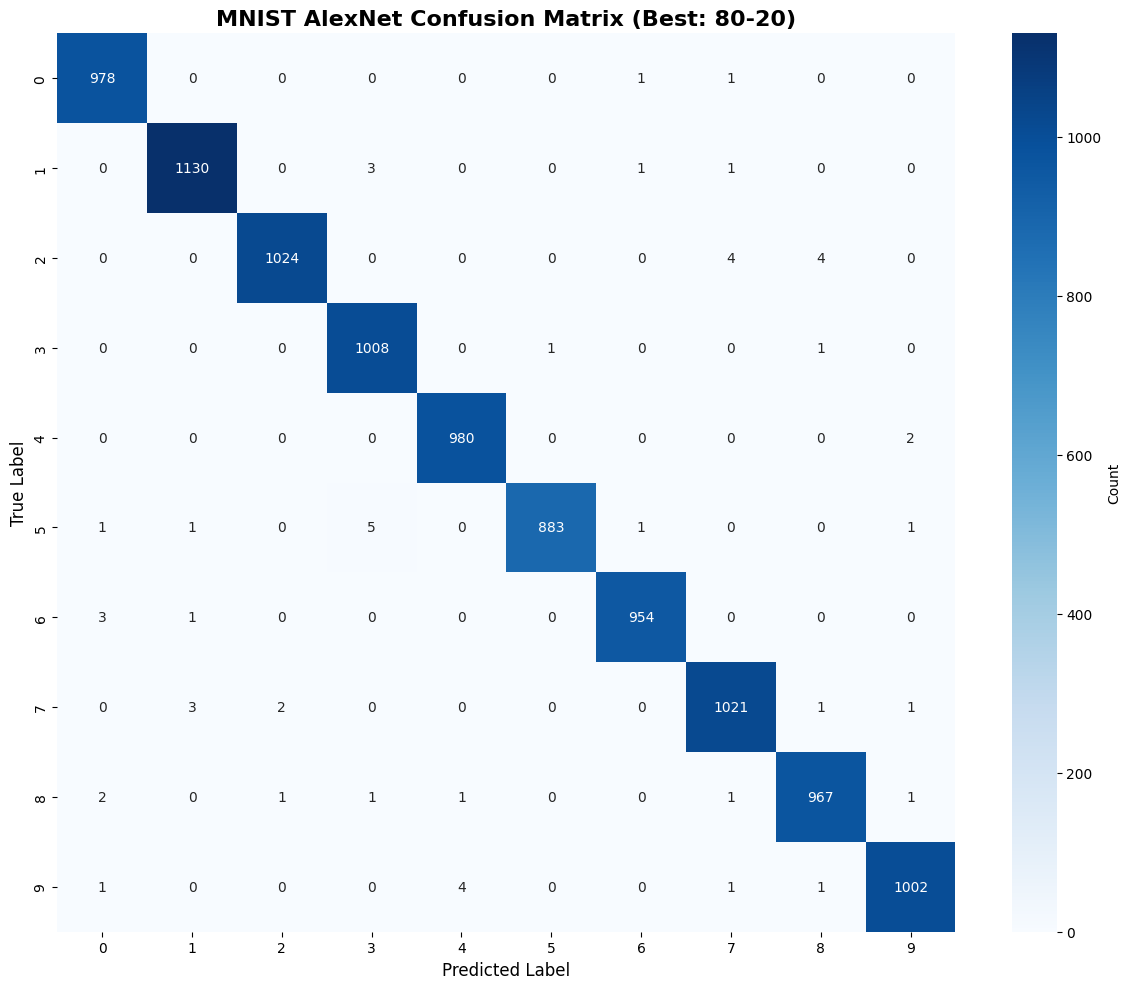

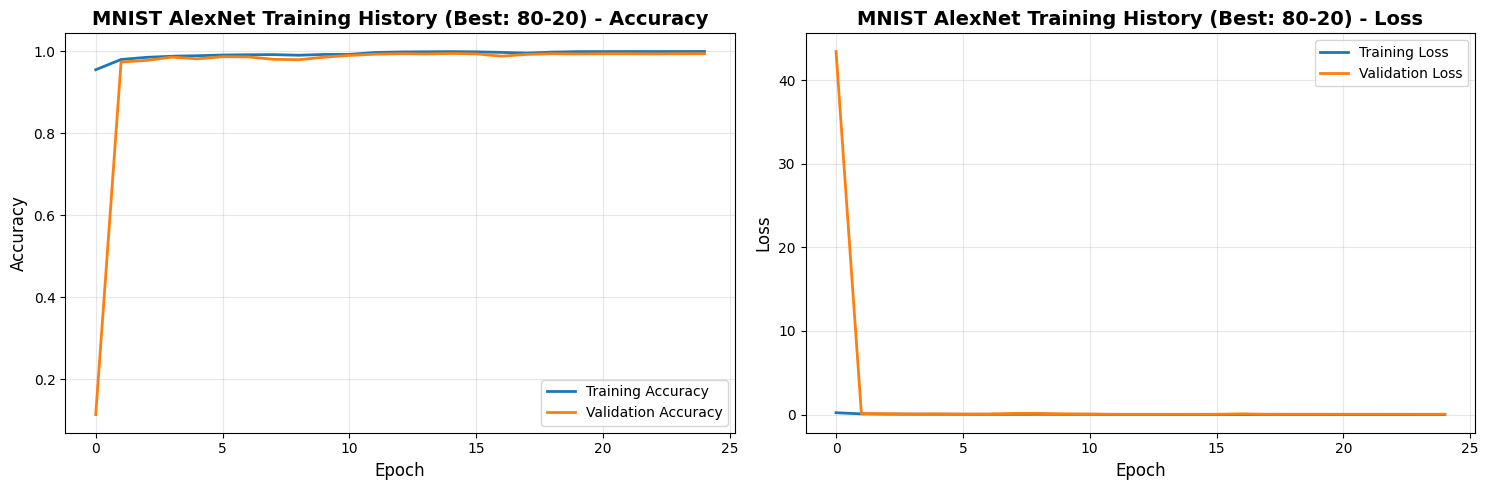

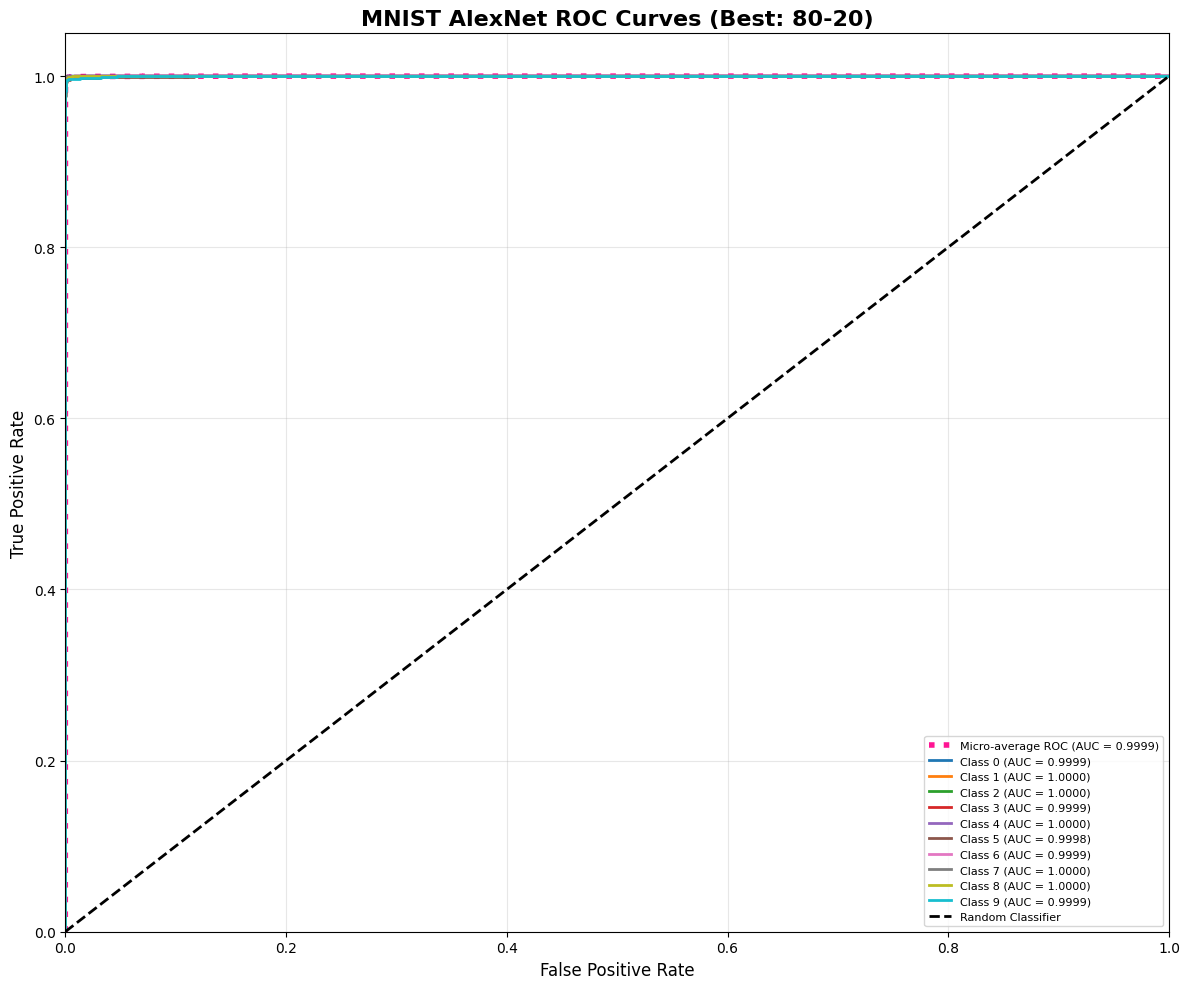


TESTING GoogLeNet ON MNIST

Training GoogLeNet on MNIST with 60-40 split

GoogLeNet Architecture:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 28, 28,    │        640 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_75[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 14, 14,    │      6,240 │ max_pooling2d_33… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 14, 14,    │      1,040 │ max_pooling2d_33… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        384 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │         64 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 14, 14,    │          0 │ max_pooling2d_33… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 14, 14,    │      4,160 │ max_pooling2d_33… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 14, 14,    │    110,720 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 14, 14,    │     12,832 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 14, 14,    │      2,080 │ max_pooling2d_34… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_81[0][0] 

 Total params: 2,232,722 (8.52 MB)

 Trainable params: 2,225,986 (8.49 MB)

 Non-trainable params: 6,736 (26.31 KB)


Training started...
Epoch 1/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 95s 158ms/step - accuracy: 0.9142 - loss: 0.2671 - val_accuracy: 0.1135 - val_loss: 13.6712 - learning_rate: 0.0010
Epoch 2/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9877 - loss: 0.0400 - val_accuracy: 0.8573 - val_loss: 0.4504 - learning_rate: 0.0010
Epoch 3/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9911 - loss: 0.0267 - val_accuracy: 0.9759 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 4/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9944 - loss: 0.0169 - val_accuracy: 0.9859 - val_loss: 0.0542 - learning_rate: 0.0010
Epoch 5/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9943 - loss: 0.0160 - val_accuracy: 0.9865 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 6/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9966 - loss: 0.0108 - val_accuracy: 0.9773 - val_loss: 0.0923 - learning_rate: 0.0010
Epoch 7/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 28, 28,    │        640 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_106[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_41    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 14, 14,    │      6,240 │ max_pooling2d_41… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 14, 14,    │      1,040 │ max_pooling2d_41… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        384 │ conv2d_108[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │         64 │ conv2d_110[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_42    │ (None, 14, 14,    │          0 │ max_pooling2d_41… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 14, 14,    │      4,160 │ max_pooling2d_41… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 14, 14,    │    110,720 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 14, 14,    │     12,832 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 14, 14,    │      2,080 │ max_pooling2d_42… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_107[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_109[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_111[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_112[0][0]

 Total params: 2,232,722 (8.52 MB)

 Trainable params: 2,225,986 (8.49 MB)

 Non-trainable params: 6,736 (26.31 KB)


Training started...
Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 88s 131ms/step - accuracy: 0.9282 - loss: 0.2321 - val_accuracy: 0.1135 - val_loss: 8.2199 - learning_rate: 0.0010
Epoch 2/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.9871 - loss: 0.0404 - val_accuracy: 0.9491 - val_loss: 0.1580 - learning_rate: 0.0010
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9929 - loss: 0.0243 - val_accuracy: 0.9126 - val_loss: 0.3201 - learning_rate: 0.0010
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.9938 - loss: 0.0189 - val_accuracy: 0.9795 - val_loss: 0.0685 - learning_rate: 0.0010
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9945 - loss: 0.0179 - val_accuracy: 0.9885 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9955 - loss: 0.0131 - val_accuracy: 0.9871 - val_loss: 0.0438 - learning_rate: 0.0010
Epoch 7/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step 

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 28, 28,    │        640 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_137[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_49    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 14, 14,    │      6,240 │ max_pooling2d_49… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 14, 14,    │      1,040 │ max_pooling2d_49… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        384 │ conv2d_139[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │         64 │ conv2d_141[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_50    │ (None, 14, 14,    │          0 │ max_pooling2d_49… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 14, 14,    │      4,160 │ max_pooling2d_49… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (None, 14, 14,    │    110,720 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 14, 14,    │     12,832 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 14, 14,    │      2,080 │ max_pooling2d_50… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_138[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_140[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_142[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_143[0][0]

 Total params: 2,232,722 (8.52 MB)

 Trainable params: 2,225,986 (8.49 MB)

 Non-trainable params: 6,736 (26.31 KB)


Training started...
Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 76ms/step - accuracy: 0.9228 - loss: 0.2370 - val_accuracy: 0.1135 - val_loss: 9.3793 - learning_rate: 0.0010
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9883 - loss: 0.0396 - val_accuracy: 0.9871 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9924 - loss: 0.0243 - val_accuracy: 0.9867 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9944 - loss: 0.0181 - val_accuracy: 0.9746 - val_loss: 0.0965 - learning_rate: 0.0010
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9955 - loss: 0.0143 - val_accuracy: 0.9668 - val_loss: 0.1121 - learning_rate: 0.0010
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9946 - loss: 0.0174 - val_accuracy: 0.9946 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step -

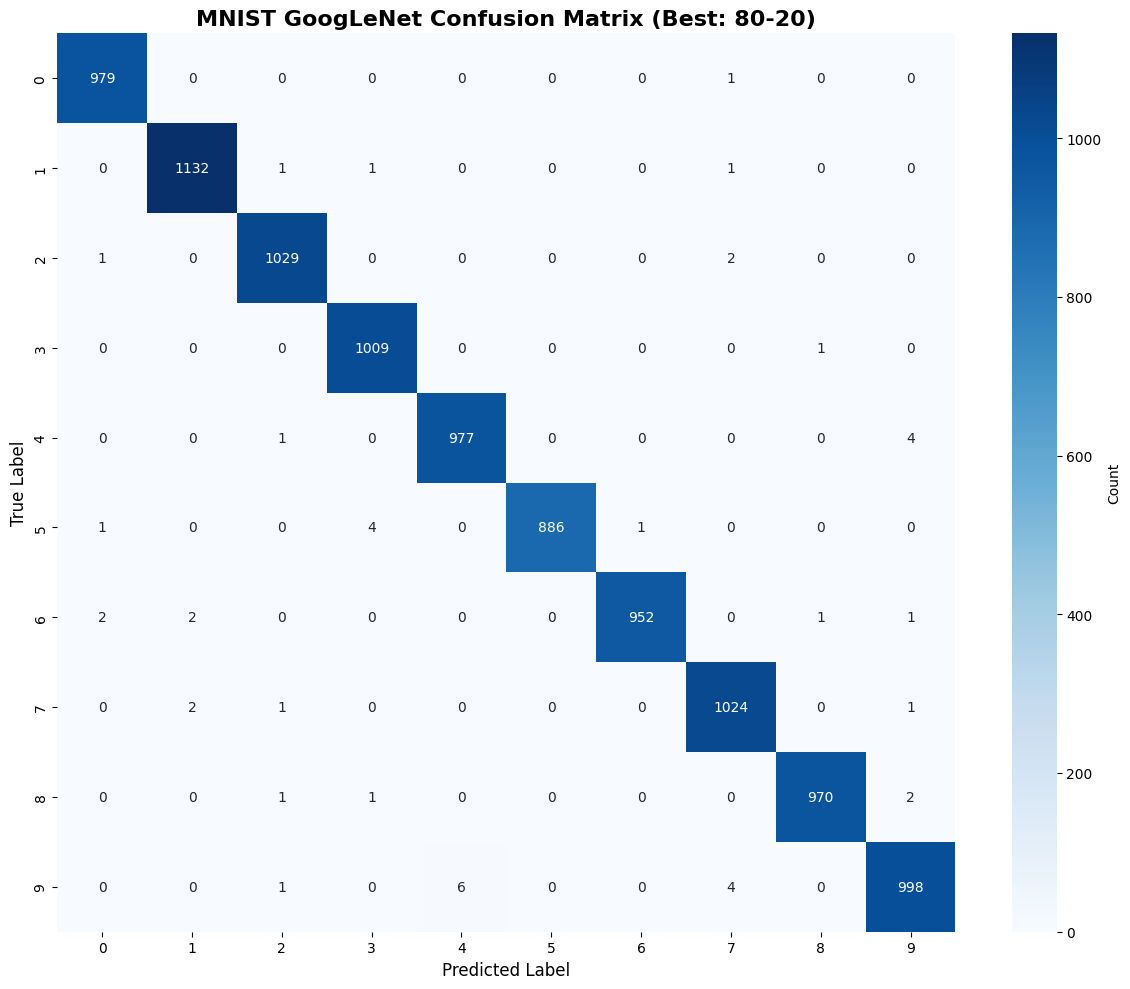

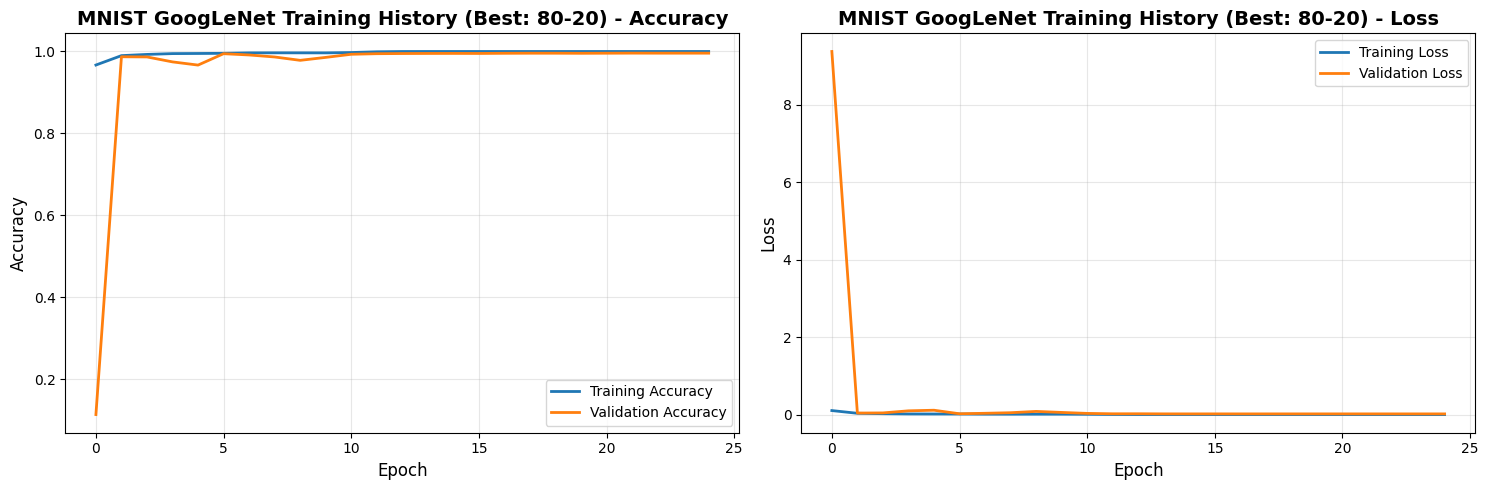

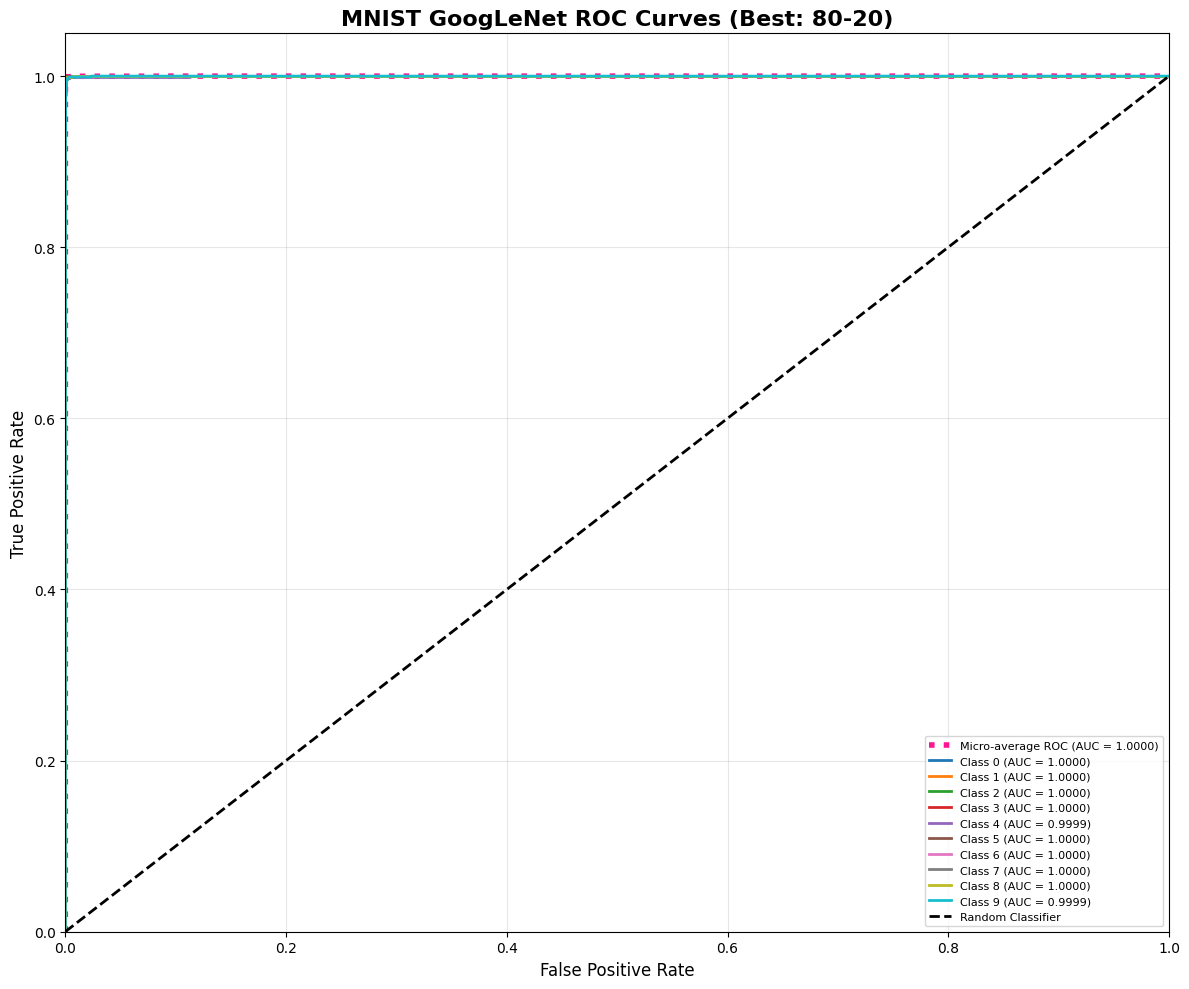


TESTING RNN ON MNIST

Training RNN on MNIST with 60-40 split

RNN Architecture:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 28, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_186         │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 28, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_187         │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_188         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_189         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,890 (1.08 MB)

 Trainable params: 281,738 (1.07 MB)

 Non-trainable params: 1,152 (4.50 KB)


Training started...
Epoch 1/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5633 - loss: 1.4427 - val_accuracy: 0.2481 - val_loss: 2.8169 - learning_rate: 0.0010
Epoch 2/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9183 - loss: 0.2767 - val_accuracy: 0.9406 - val_loss: 0.2088 - learning_rate: 0.0010
Epoch 3/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9529 - loss: 0.1659 - val_accuracy: 0.9653 - val_loss: 0.1260 - learning_rate: 0.0010
Epoch 4/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9662 - loss: 0.1177 - val_accuracy: 0.9722 - val_loss: 0.0988 - learning_rate: 0.0010
Epoch 5/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9721 - loss: 0.0969 - val_accuracy: 0.9777 - val_loss: 0.0834 - learning_rate: 0.0010
Epoch 6/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9759 - loss: 0.0829 - val_accuracy: 0.9792 - val_loss: 0.0819 - learning_rate: 0.0010
Epoch 7/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accur

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 28, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_190         │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 28, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_191         │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_192         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_193         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,890 (1.08 MB)

 Trainable params: 281,738 (1.07 MB)

 Non-trainable params: 1,152 (4.50 KB)


Training started...
Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5913 - loss: 1.3711 - val_accuracy: 0.5430 - val_loss: 1.5623 - learning_rate: 0.0010
Epoch 2/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9282 - loss: 0.2433 - val_accuracy: 0.9590 - val_loss: 0.1291 - learning_rate: 0.0010
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9556 - loss: 0.1563 - val_accuracy: 0.9661 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9670 - loss: 0.1123 - val_accuracy: 0.9688 - val_loss: 0.1246 - learning_rate: 0.0010
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9739 - loss: 0.0980 - val_accuracy: 0.9796 - val_loss: 0.0697 - learning_rate: 0.0010
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9780 - loss: 0.0745 - val_accuracy: 0.9784 - val_loss: 0.0775 - learning_rate: 0.0010
Epoch 7/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accur

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 28, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_194         │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 28, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_195         │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_196         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_197         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,890 (1.08 MB)

 Trainable params: 281,738 (1.07 MB)

 Non-trainable params: 1,152 (4.50 KB)


Training started...
Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6244 - loss: 1.2302 - val_accuracy: 0.8663 - val_loss: 0.4151 - learning_rate: 0.0010
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9398 - loss: 0.2151 - val_accuracy: 0.9713 - val_loss: 0.1008 - learning_rate: 0.0010
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9620 - loss: 0.1328 - val_accuracy: 0.9756 - val_loss: 0.0848 - learning_rate: 0.0010
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9686 - loss: 0.1045 - val_accuracy: 0.9660 - val_loss: 0.1244 - learning_rate: 0.0010
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9764 - loss: 0.0844 - val_accuracy: 0.9825 - val_loss: 0.0733 - learning_rate: 0.0010
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9793 - loss: 0.0742 - val_accuracy: 0.9780 - val_loss: 0.0825 - learning_rate: 0.0010
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accur

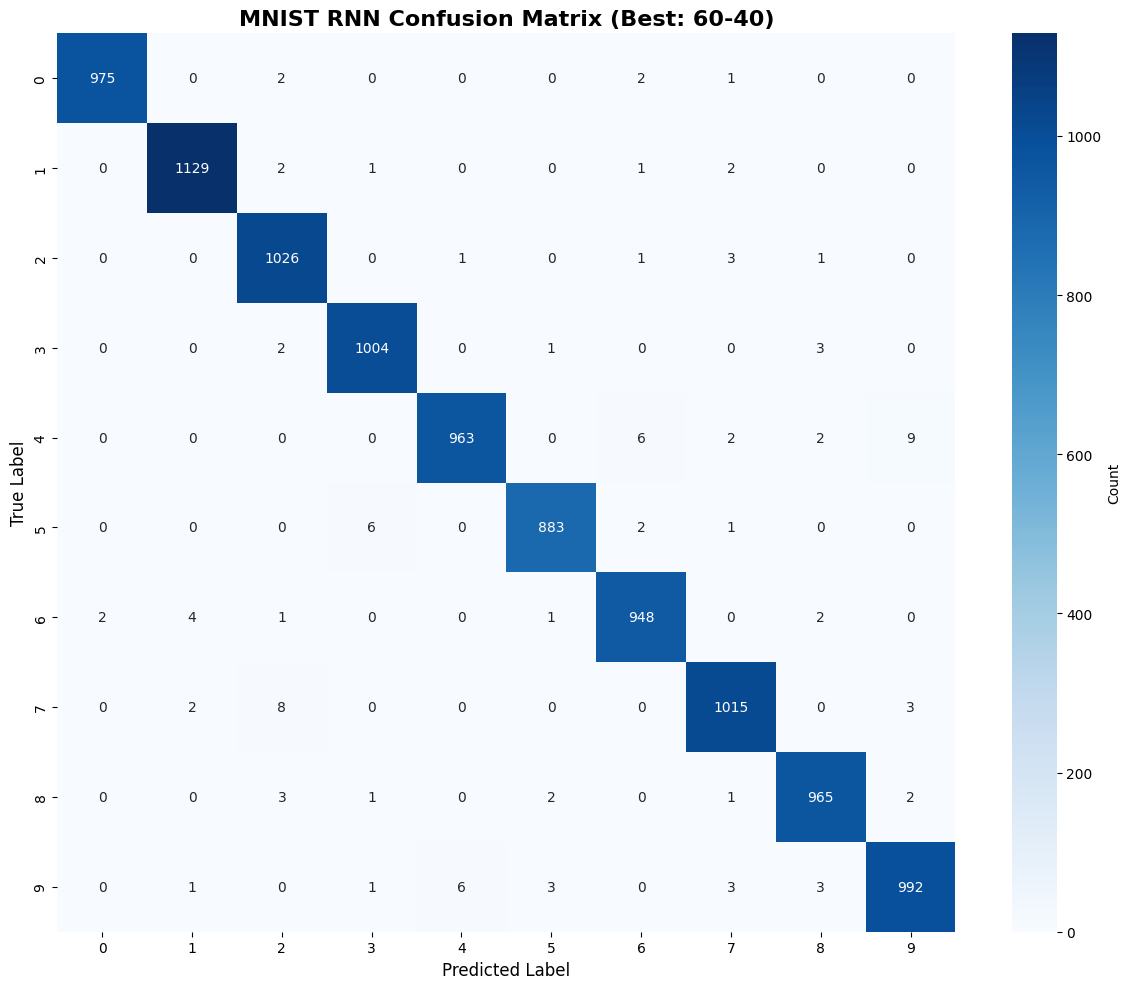

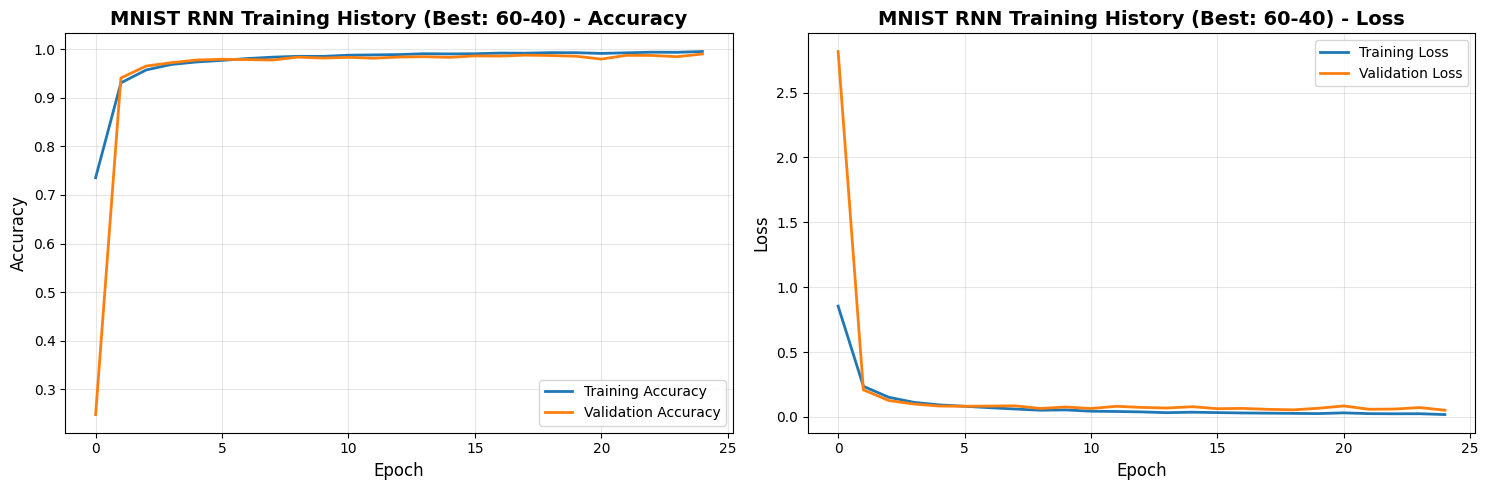

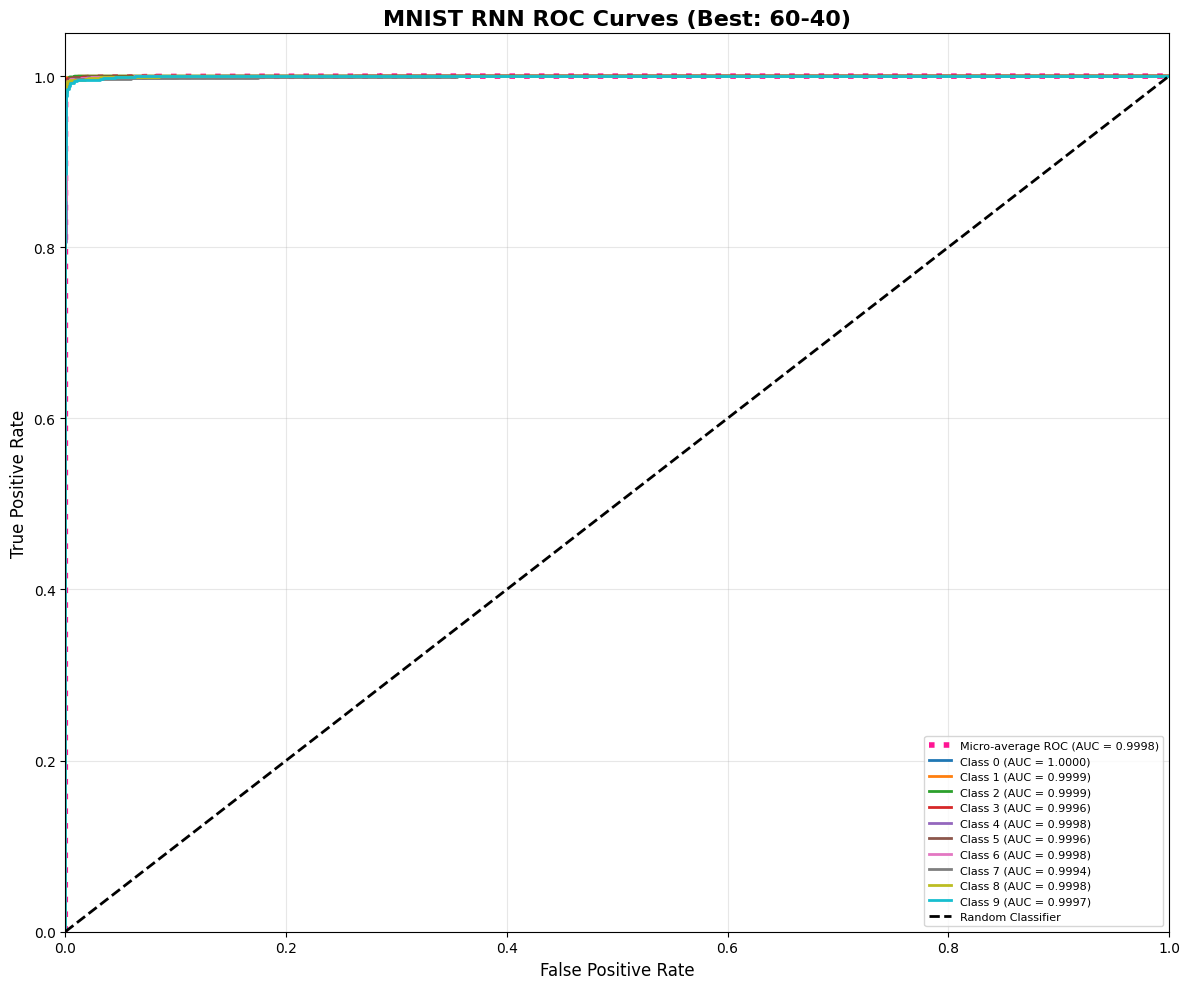

In [10]:

# ============================================================================
# MNIST EXPERIMENTS
# ============================================================================

print("\n" + "="*80)
print("MNIST EXPERIMENTS")
print("="*80)

for model_name, model_creator in models_config.items():
    print(f"\n{'='*80}")
    print(f"TESTING {model_name} ON MNIST")
    print(f"{'='*80}")

    model_results = []

    for split_ratio in split_ratios:
        # Create train-validation split
        X_train, X_val, y_train, y_val = train_test_split(
            X_mnist_train_full, y_mnist_train_full,
            train_size=split_ratio, random_state=42, stratify=y_mnist_train_full
        )

        # Convert labels to categorical
        y_train_cat = to_categorical(y_train, 10)
        y_val_cat = to_categorical(y_val, 10)
        y_test_cat = to_categorical(y_mnist_test, 10)

        # Adjust model input shape for MNIST
        if model_name == 'RNN':
            model_func = lambda: model_creator(input_shape=(28, 28, 1), num_classes=10)
        else:
            model_func = lambda: model_creator(input_shape=(28, 28, 1), num_classes=10)

        
        epochs = 25

        # Train model
        try:
            model, history, y_true, y_pred, y_pred_proba, test_acc, test_loss = train_and_evaluate(
                X_train, X_mnist_test, y_train_cat, y_test_cat,
                model_func,
                model_name,
                'MNIST',
                f"{int(split_ratio*100)}-{round((1-split_ratio)*100)}",
                epochs=epochs,
                batch_size=128,
                use_augmentation=False
            )

            # Store results
            model_results.append({
                'Dataset': 'MNIST',
                'Model': model_name,
                'Split': f"{int(split_ratio*100)}-{round((1-split_ratio)*100)}",
                'Train Size': len(X_train),
                'Test Size': len(X_mnist_test),
                'Test Accuracy': test_acc,
                'Test Loss': test_loss,
                'model_obj': model,
                'History': history,
                'y_true': y_true,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            })

        except Exception as e:
            print(f"Error training {model_name} with split {split_ratio}: {str(e)}")
            continue

    # Find best result for this model on MNIST
    if model_results:
        best_result = max(model_results, key=lambda x: x['Test Accuracy'])
        all_results.extend(model_results)

        # Generate visualizations for best case
        print(f"\nGenerating visualizations for best {model_name} on MNIST...")

        # Confusion Matrix
        plot_confusion_matrix(
            best_result['y_true'],
            best_result['y_pred'],
            mnist_classes,
            f"MNIST {model_name} Confusion Matrix (Best: {best_result['Split']})",
            f'mnist_{model_name.lower()}_confusion_matrix.png'
        )

        # Training curves
        plot_training_history(
            best_result['History'],
            f"MNIST {model_name} Training History (Best: {best_result['Split']})",
            f'mnist_{model_name.lower()}_training_curves.png'
        )

        # ROC-AUC
        auc_score = plot_roc_auc_multiclass(
            best_result['y_true'],
            best_result['y_pred_proba'],
            10,
            mnist_classes,
            f"MNIST {model_name} ROC Curves (Best: {best_result['Split']})",
            f'mnist_{model_name.lower()}_roc_auc.png'
        )

        best_result['AUC'] = auc_score

In [11]:

# ============================================================================
# COMPREHENSIVE RESULTS TABLE
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS TABLE")
print("="*80)

# Create results dataframe
results_data = []
for result in all_results:
    results_data.append({
        'Dataset': result['Dataset'],
        'Model': result['Model'],
        'Split Ratio': result['Split'],
        'Train Samples': result['Train Size'],
        'Test Samples': result['Test Size'],
        'Test Accuracy (%)': f"{result['Test Accuracy']*100:.2f}",
        'Test Loss': f"{result['Test Loss']:.4f}",
        'Final Train Acc (%)': f"{result['History'].history['accuracy'][-1]*100:.2f}",
        'Final Val Acc (%)': f"{result['History'].history['val_accuracy'][-1]*100:.2f}"
    })

results_df = pd.DataFrame(results_data)
print("\n", results_df.to_string(index=False))

# Save results
results_df.to_csv('all_models_comparison_results.csv', index=False)
print("\nResults saved to 'all_models_comparison_results.csv'")


COMPREHENSIVE RESULTS TABLE

 Dataset     Model Split Ratio  Train Samples  Test Samples Test Accuracy (%) Test Loss Final Train Acc (%) Final Val Acc (%)
  MNIST     VGG16       60-40          36000         10000             99.41    0.0231              100.00             99.52
  MNIST     VGG16       70-30          42000         10000             99.48    0.0260               99.96             99.06
  MNIST     VGG16       80-20          48000         10000             99.39    0.0223              100.00             99.54
  MNIST   AlexNet       60-40          36000         10000             99.31    0.0375              100.00             99.44
  MNIST   AlexNet       70-30          42000         10000             99.45    0.0459               99.93             99.43
  MNIST   AlexNet       80-20          48000         10000             99.47    0.0305              100.00             99.47
  MNIST GoogLeNet       60-40          36000         10000             99.47    0.0204        

In [12]:

# ============================================================================
# BEST MODELS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("BEST MODELS SUMMARY (BY DATASET)")
print("="*80)

# Find best model for each dataset
best_models_summary = []

for dataset in ['CIFAR-10', 'MNIST']:
    dataset_results = [r for r in all_results if r['Dataset'] == dataset]
    if dataset_results:
        best = max(dataset_results, key=lambda x: x['Test Accuracy'])
        best_models_summary.append({
            'Dataset': dataset,
            'Best Model': best['Model'],
            'Split': best['Split'],
            'Test Accuracy (%)': f"{best['Test Accuracy']*100:.2f}",
            'Test Loss': f"{best['Test Loss']:.4f}",
            'AUC Score': f"{best.get('AUC', 0):.4f}",
            'Train Samples': best['Train Size']
        })

best_summary_df = pd.DataFrame(best_models_summary)
print("\n", best_summary_df.to_string(index=False))


BEST MODELS SUMMARY (BY DATASET)

 Dataset Best Model Split Test Accuracy (%) Test Loss AUC Score  Train Samples
  MNIST  GoogLeNet 80-20             99.56    0.0174    1.0000          48000
